In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, FuncFormatter, FormatStrFormatter
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
import solar_plotting

from spectrum import pmtm
import pywt
from scipy.signal import welch
from scipy.signal import convolve

import geopandas as gpd
import pyogrio
import rasterio
from rasterio.mask import mask
from pyproj import CRS
from shapely.geometry import Point

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

In [4]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/REZ/CF/'

In [5]:
import logging
logging.getLogger("flox").setLevel(logging.WARNING)

# Prepare Data

In [6]:
# regions = ['Q', 'N', 'V', 'S', 'T']  # States
regions = ['Q2', 'Q8', 'N3', 'N5', 'V5', 'V6', 'T1', 'T3', 'S7', 'S8'] # REZs
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/capacity_factor/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds = xr.Dataset(region_darrays)
ds = ds.load()

time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

In [7]:
# Rated capacity taken from sandia_modules['Canadian_Solar_CS5P_220M___2009_'], solar panel used in pvlib system,
# using the calculation rated_capacity = module.loc['Impo'] * module.loc['Vmpo']
rated_capacity = 219.656729124
ds = ds.apply(lambda x: x / rated_capacity) # raw data can be used for load duration curves, before morning/evening data is removed in "clip_dusk_dawn"

# Remove missing middle of the day time

In [8]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Bad data

## Investigation

In [8]:
# Group by day
grouped = ds_aus.groupby('time.date')

# Function to get difference between 32nd and 33rd index (i.e., index 31 and 32)
def get_daily_diff(group):
    try:
        return group.isel(time=33) - group.isel(time=32)
    except IndexError:
        # If a day has fewer than 33 time steps (e.g., incomplete day), skip
        return xr.full_like(group.isel(time=0), fill_value=np.nan)

# Apply to all variables
diffs = {}
for var in ds_aus.data_vars:
    diffs[var] = grouped.map(lambda g: get_daily_diff(g[var]))

# Combine into a Dataset
diff_ds = xr.Dataset(diffs)

# Convert to DataFrame for easier plotting
diff_df = diff_ds.to_dataframe()

2019-08-12T10:00:00.000000000


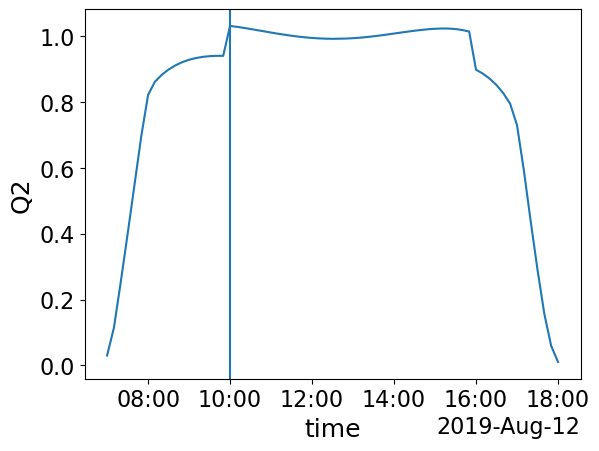

2019-10-01T10:00:00.000000000


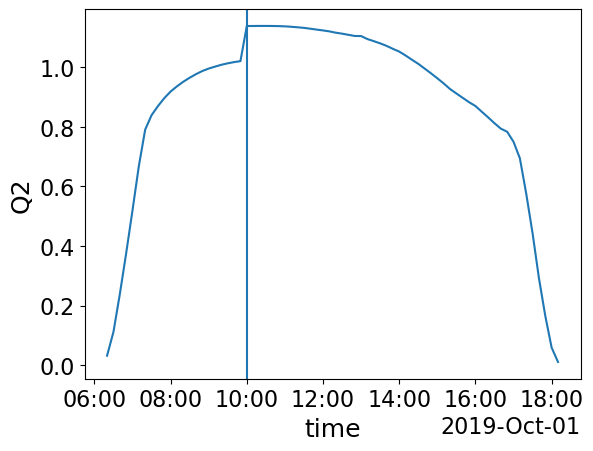

2020-09-06T10:00:00.000000000


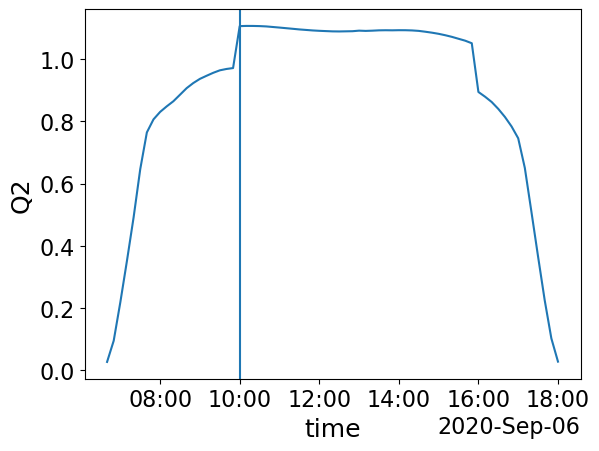

2024-02-02T10:00:00.000000000


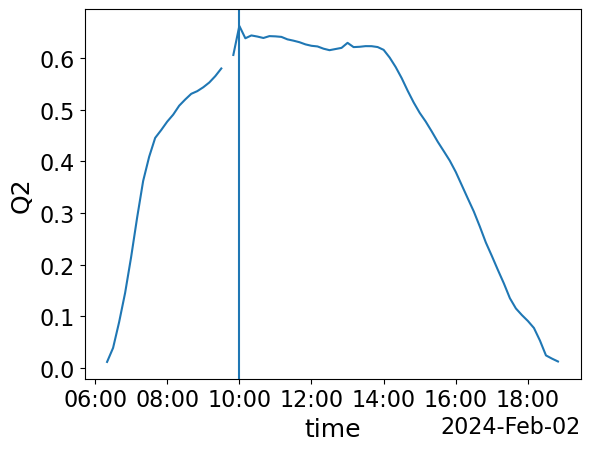

In [10]:
reg = 'Q2'
for date in diff_df[diff_df[reg] > 0.05].index:
    data = ds_aus[reg].sel(time=f'{date}')
    data.plot()
    bad_time = data.time.values[33]
    print(bad_time)
    plt.axvline(bad_time)
    plt.show()

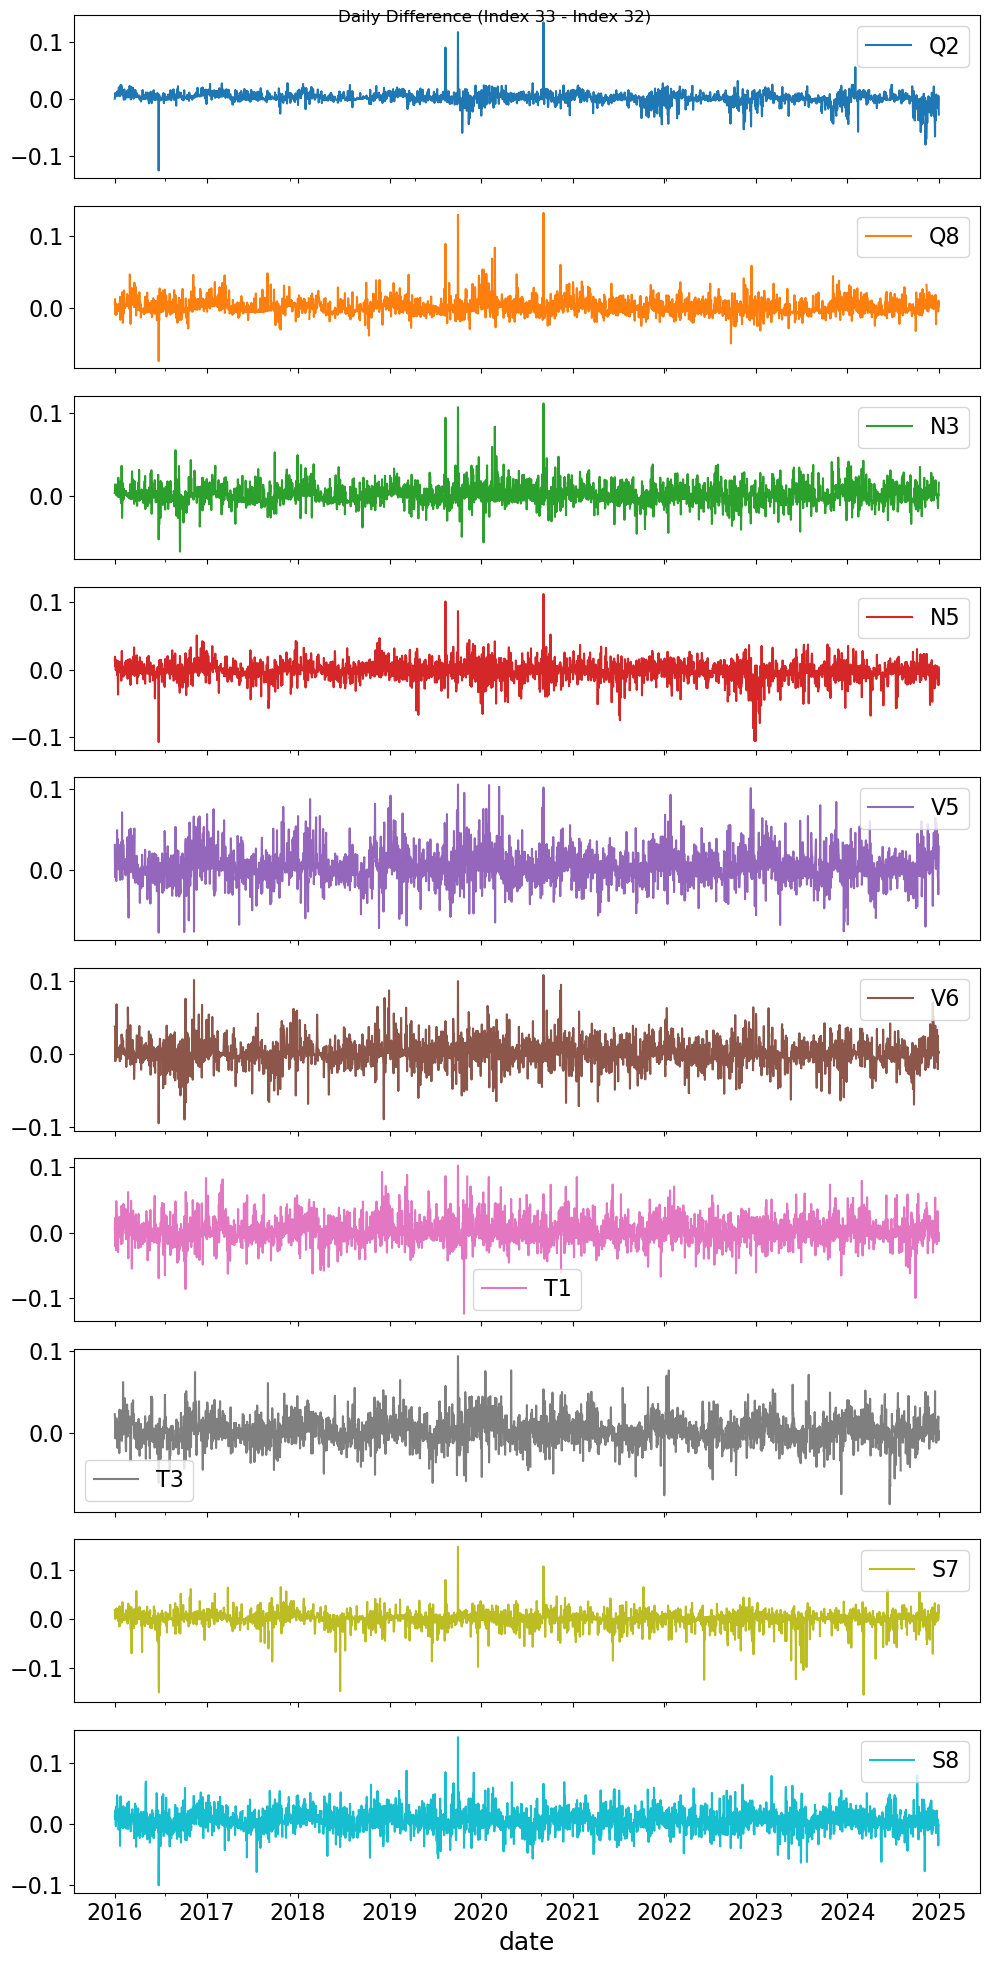

In [16]:
# Plot each variable
diff_df.plot(subplots=True,
             figsize=(10, len(diff_df.columns) * 2),
             title="Daily Difference (Index 33 - Index 32)",
             # ylim=(0,0.1)
            )
plt.tight_layout()
plt.show()

In [106]:
for reg in regions:
    max_ = ds_aus[reg].max().data
    print(reg)
    print(ds_aus[reg][ds_aus[reg] == max_].time.data)

Q2
['2019-10-01T10:20:00.000000000']
Q8
['2024-12-24T11:00:00.000000000']
N3
['2018-01-16T10:10:00.000000000']
N5
['2020-01-02T10:40:00.000000000']
V5
['2022-12-19T11:30:00.000000000']
V6
['2019-12-22T10:40:00.000000000']
S7
['2020-01-02T11:50:00.000000000']
S8
['2020-01-01T11:00:00.000000000']
T1
['2019-12-22T10:00:00.000000000']
T3
['2018-12-30T10:00:00.000000000']


## Remove bad days

In [9]:
bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

# Clip Dusk and Dawn

In [10]:
# REMOVE BAD DUSK AND DAWN DATA
for reg in regions:
    ds[reg] = solar_plotting.clip_dusk_dawn(ds[reg], n=6)

# Make a combined "total" variable to represent all regions

In [8]:
stacked = xr.concat([ds_aus[var] for var in ds_aus.data_vars], dim="region")
total = stacked.mean(dim="region")
ds_aus["total"] = total

# Map of Zones

In [23]:
rez_file = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/Indicative REZ boundaries 2024 GIS data.kml'
rez = gpd.read_file(rez_file, engine='pyogrio')

rez['Name'] = rez['Name'].str[:2]

In [54]:
zone_means = {reg: ds[reg].mean(dim='time').item() for reg in regions}

hourly_shortages = {}
daily_droughts = {}
drought_lengths = np.linspace(6,72,23)
for reg in regions:
    hourly = solar_plotting.mean_below_threshold(ds[reg], 0.17, drought_lengths)
    hourly_shortages[reg] = np.sum(hourly[0] * hourly[1])

    daily = solar_plotting.daily_drought(ds[reg], rolling_threshold=0.292/4, day_threshold=0.292, window=6)
    daily_droughts[reg] = np.sum(daily[0] * daily[1])

rez['mean'] = rez['Name'].map(zone_means)
rez['shortage'] = rez['Name'].map(hourly_shortages)
rez['drought'] = rez['Name'].map(daily_droughts)


rez = rez.dropna(subset=['mean'])

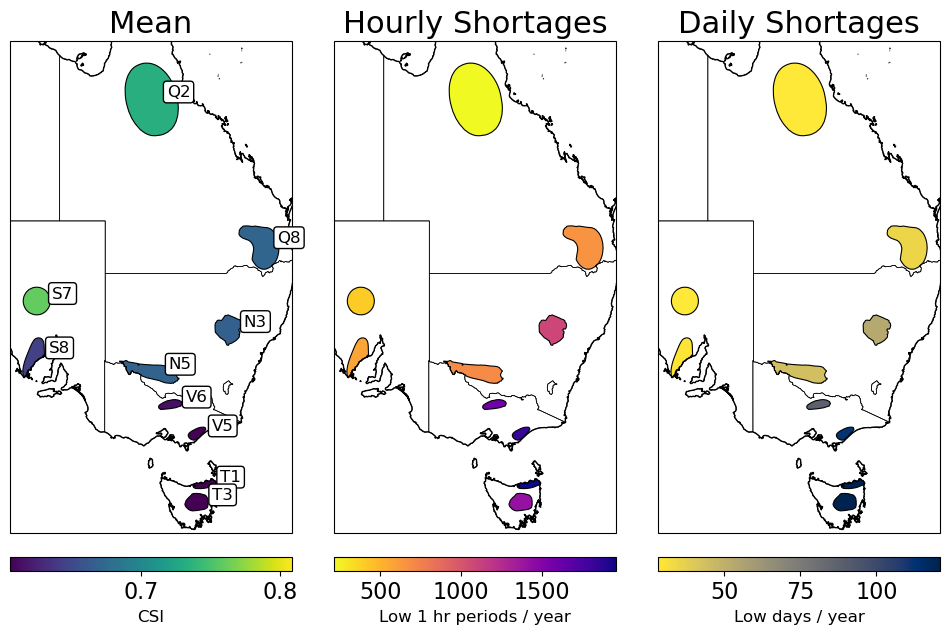

In [69]:
# Define the variables and titles to plot
plot_vars = ['mean', 'shortage', 'drought']
titles = ['Mean', 'Hourly Shortages', 'Daily Shortages']
cbar_lab = ['CF', 'Low 1 hr periods / year', 'Low days / year']
cmaps = ['viridis', 'plasma_r', 'cividis_r']
# Hard coded numbers taken from CSI notebook, for direct comparison
vmins = [0.6055831154515298, 215.33333333333331, 28.222222222222225]
vmaxs = [0.8083971838296977, 1956.4999999999998, 120.88888888888889]

# Create subplots with less horizontal spacing
fig, axes = plt.subplots(
    1, 3,
    figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Reproject once
rez_4326 = rez.to_crs(epsg=4326)

# Loop over variables
for i, var in enumerate(plot_vars):
    ax = axes[i]
    
    # Plot the zones
    rez_4326.plot(
        column=var,
        ax=ax,
        cmap=cmaps[i],
        edgecolor='black',
        linewidth=0.8,
        legend=False,
        vmin=vmins[i],
        vmax=vmaxs[i]
    )
    
    # Add features
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)
    ax.set_title(titles[i])

    # Add colorbar below each plot, sized to the width of its axis
    sm = mpl.cm.ScalarMappable(cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=vmins[i], vmax=vmaxs[i]))
    sm._A = []
    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='horizontal',
        pad=0.04,
        fraction=0.035,
    )
    cbar.set_label(cbar_lab[i], fontsize=12)

# Reduce space between plots
plt.subplots_adjust(wspace=0.15, bottom=0.15)


from shapely.geometry import MultiPolygon

# Add labels offset to the top-right of each geometry
for idx, row in rez_4326.iterrows():
    geom = row['geometry']
    if geom.is_empty:
        continue
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda a: a.area)  # Use the largest polygon

    centroid = geom.centroid
    x, y = centroid.x + 1, centroid.y  # Offset coordinates (adjust as needed)

    axes[0].text(
        x, y,
        row['Name'],
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=12,
        transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
    )


plt.savefig(f'{fig_dir}/CF-REZ-map.png')
plt.show()

# Constant below threshold

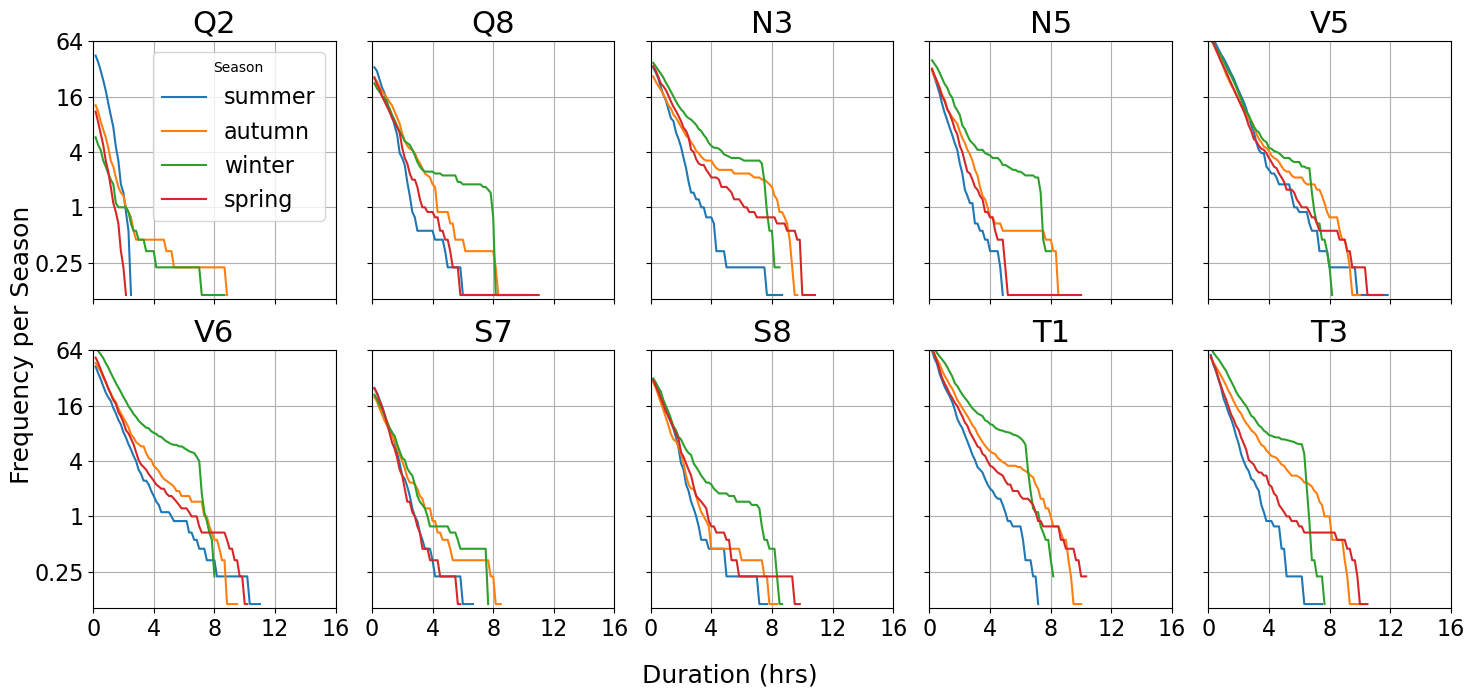

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 7), sharex=True, sharey=True)
ax = ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.constant_below_threshold(da=ds_aus[reg], threshold=0.2)
    for season in cbt:
        x = np.array(cbt[season][0])
        y = np.array(cbt[season][1])
        ax[i].plot(x[y > 0], y[y > 0], label=season)
    ax[i].set_title(reg)
    ax[i].grid(True)

    # Set log scale and custom tick formatting for y-axis
    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax[0].legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

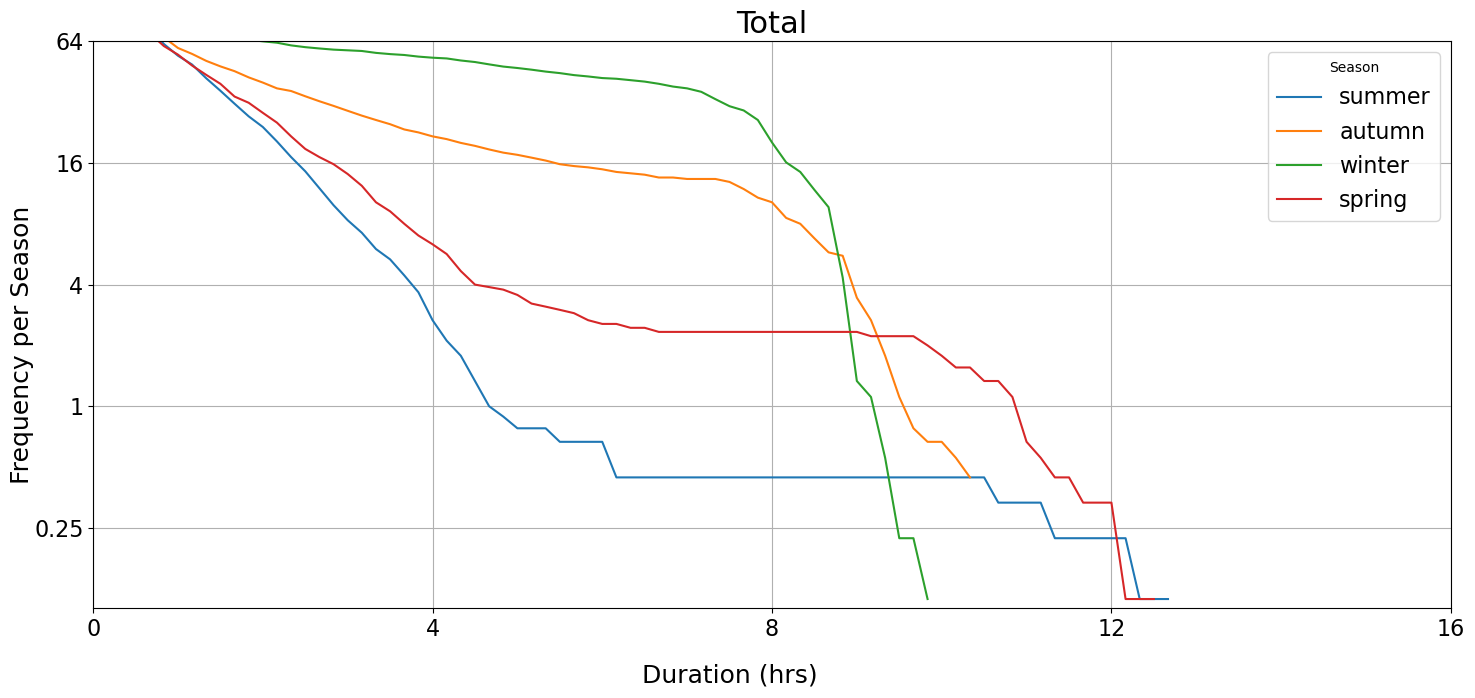

In [10]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True, sharey=True)


cbt = solar_plotting.constant_below_threshold(da=ds_aus.total, threshold=0.5)
for season in cbt:
    x = np.array(cbt[season][0])
    y = np.array(cbt[season][1])
    ax.plot(x[y > 0], y[y > 0], label=season)
ax.set_title("Total")
ax.grid(True)

# Set log scale and custom tick formatting for y-axis
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax.legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

# Mean Below Threshold

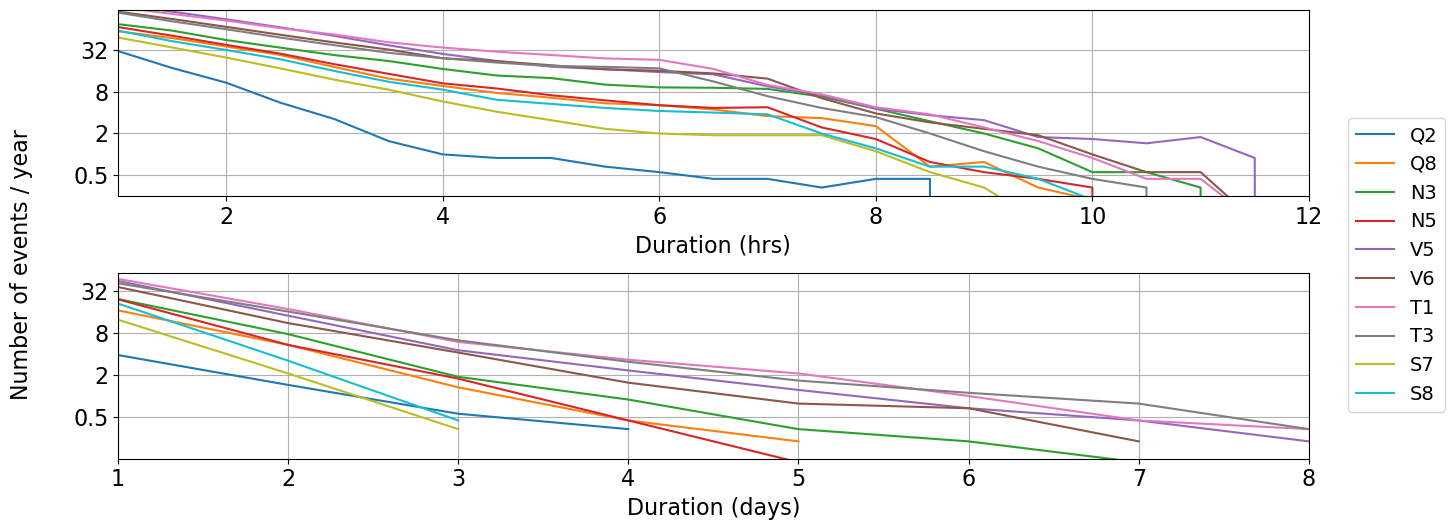

In [70]:
drought_lengths = np.linspace(6, 72, 23)

def format_ticks(val, _):
    if val < 1:
        return f"{val:.1f}"  # Show decimals like 0.5
    else:
        return f"{int(val)}"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
ax.flatten()

for reg in regions:
    # Hourly MBT
    x_data, mbt_droughts = solar_plotting.mean_below_threshold(ds[reg], 0.17, drought_lengths)
    # x_data = np.divide(sorted(drought_lengths, reverse=True), 6)
    ax[0].plot(x_data, mbt_droughts, label=reg)
    ax[0].grid(True)
    ax[0].set_xlabel('Duration (hrs)', fontsize=16)
    ax[0].set_xlim(1,12)
    ax[0].set_ylim(0.25,120)
    ax[0].set_yscale('log', base=2)
    ax[0].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax[0].set_yticks([0.5, 2, 8, 32])

    # Daily continuous
    x, y = solar_plotting.daily_drought(
        ds[reg],
        rolling_threshold=0.292/4,
        day_threshold=0.292,
        window=6
    )
    ax[1].plot(x, y, label=reg)
    ax[1].set_xlim(1,8)
    ax[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
    ax[1].set_ylim(0.125,60)
    ax[1].grid(True)
    ax[1].set_xlabel('Duration (days)', fontsize=16)
    ax[1].set_yscale('log', base=2)
    ax[1].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax[1].set_yticks([0.5, 2, 8, 32])

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
fig.supylabel('Number of events / year', fontsize=16)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=14)

plt.savefig(f'{fig_dir}/CF-hourly-daily-shortages.png')

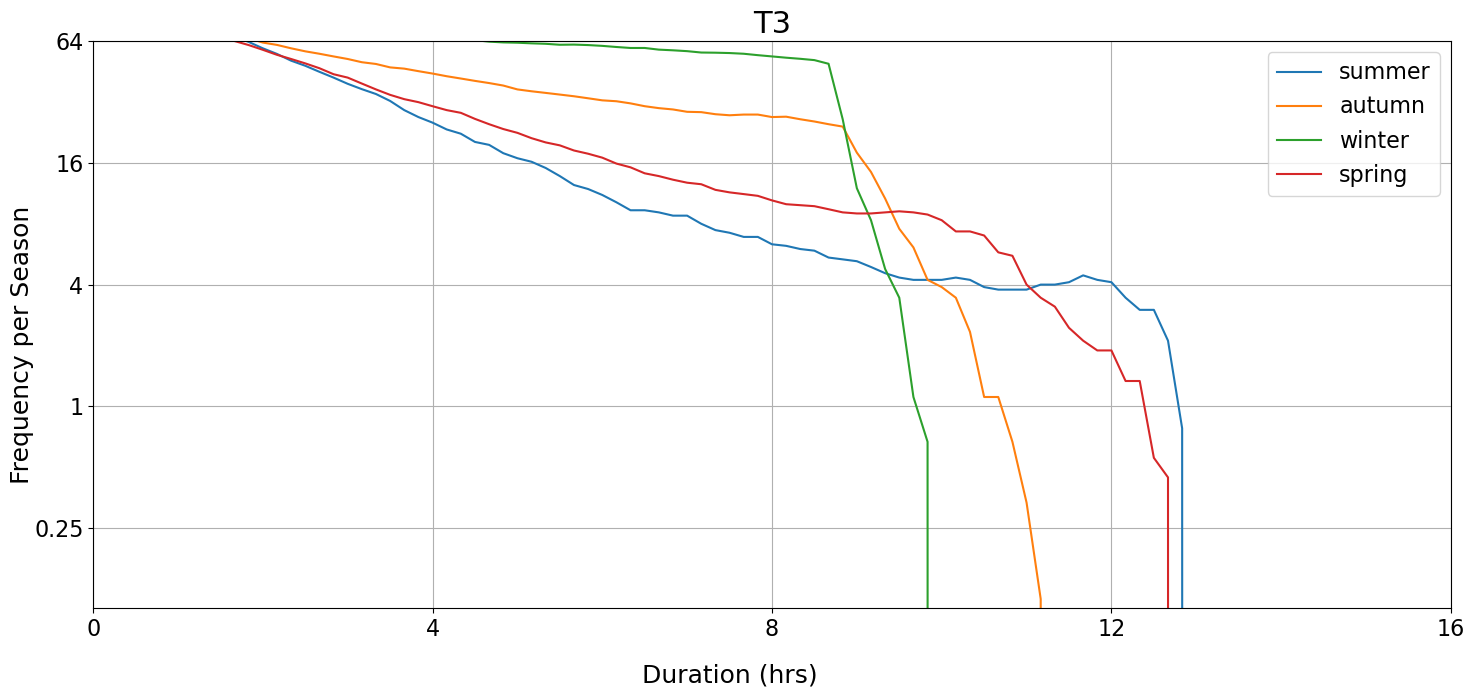

In [12]:
fig, ax = plt.subplots(figsize=(15,7), sharex=True, sharey=True)

mbt = solar_plotting.mean_below_threshold(da=ds_aus.total, threshold=0.5, max_hours=16)
mbt.plot(ax=ax)
ax.set_title(reg, rotation=0)
ax.set_xlabel('')
ax.legend().remove()
ax.grid(True)

ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


if len(regions) % 2 == 1:
    ax.axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax.legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax.legend()


fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,16)
plt.xticks(range(0,17, 4))
plt.ylim(0.1,64)
plt.tight_layout()
plt.show()

# Multi-Day Droughts

/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp_da = xr.DataArray(res, coords={'time': dates}, dims='time')
/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 v

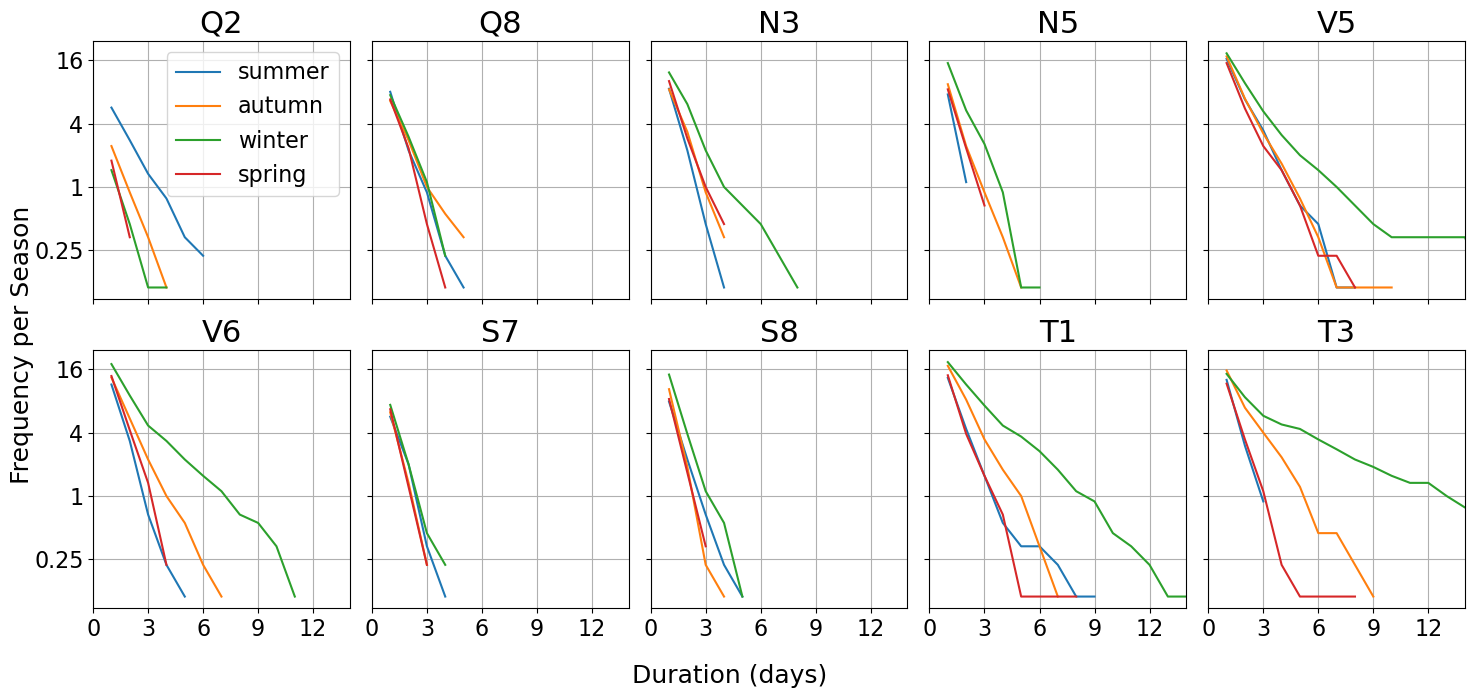

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.daily_drought(
        da=ds_aus[reg], 
        threshold = 0.2,
        tot_time=12,
        max_len=6,
        day_mean=0.2,
        day_sum=15
    )
    for season in cbt:
        ax[i].plot(cbt[season][0], cbt[season][1], label=season)
    ax[i].set_title(reg)
    ax[0].legend()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()

fig.supxlabel('Duration (days)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,14)
plt.xticks(range(0, 14, 3))
plt.tight_layout()
plt.show()

# Day/time Heatmap

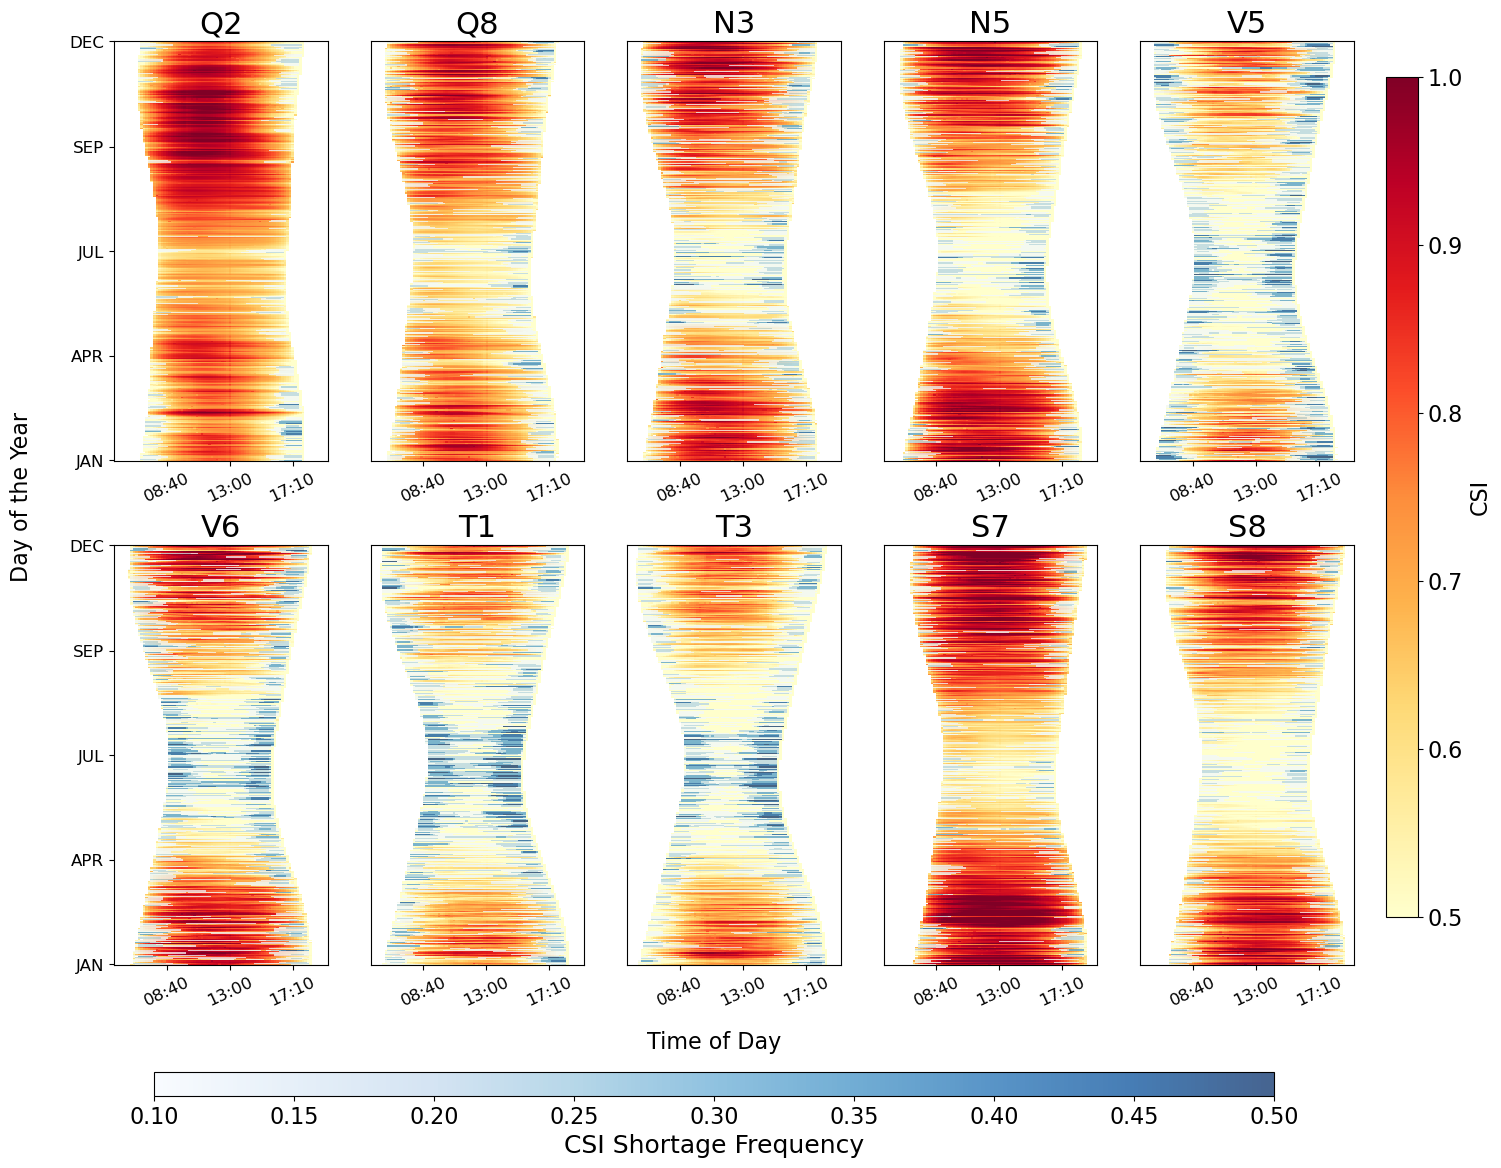

In [71]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 12))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.001, 0.7, 0.02])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )
cmap_droughts = plt.cm.Blues.copy()

cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')

im = None
im_droughts = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    df = solar_plotting.day_time_df(ds[reg])
    df = df.drop(df.columns[49], axis=1)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(ds[reg], threshold = 0.17, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    # df_droughts[~df_droughts.isna()] = 1
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0.1, vmax=0.5, interpolation='none', zorder=1, alpha=0.75)

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 5, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax[row, col].set_xticks(xticks)
    ax[row, col].set_xticklabels(xtick_labels, rotation=25, fontsize=12)

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg)

fig.colorbar(im, cax=cbar_ax).set_label('CF', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('CSI Shortage Frequency')
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

plt.savefig(f'{fig_dir}/CF-heatmap.png')
plt.show()

In [15]:
# Inlcude overnight 0 values for load duration curve
def full_time(da):
    data = da.copy() 
    times = pd.date_range(data.time.values.min(), data.time.values.max(), freq='10min')
    data = data.reindex(time=times, fill_value=0)
    
    data['time'] = pd.to_datetime(data.time.values)
    hour = data['time'].dt.hour
    day_mask = (hour >= 9) & (hour <= 16)
    data = data.where(~(~day_mask & np.isnan(data)), 0)
    data = data.dropna(dim='time')
    return data

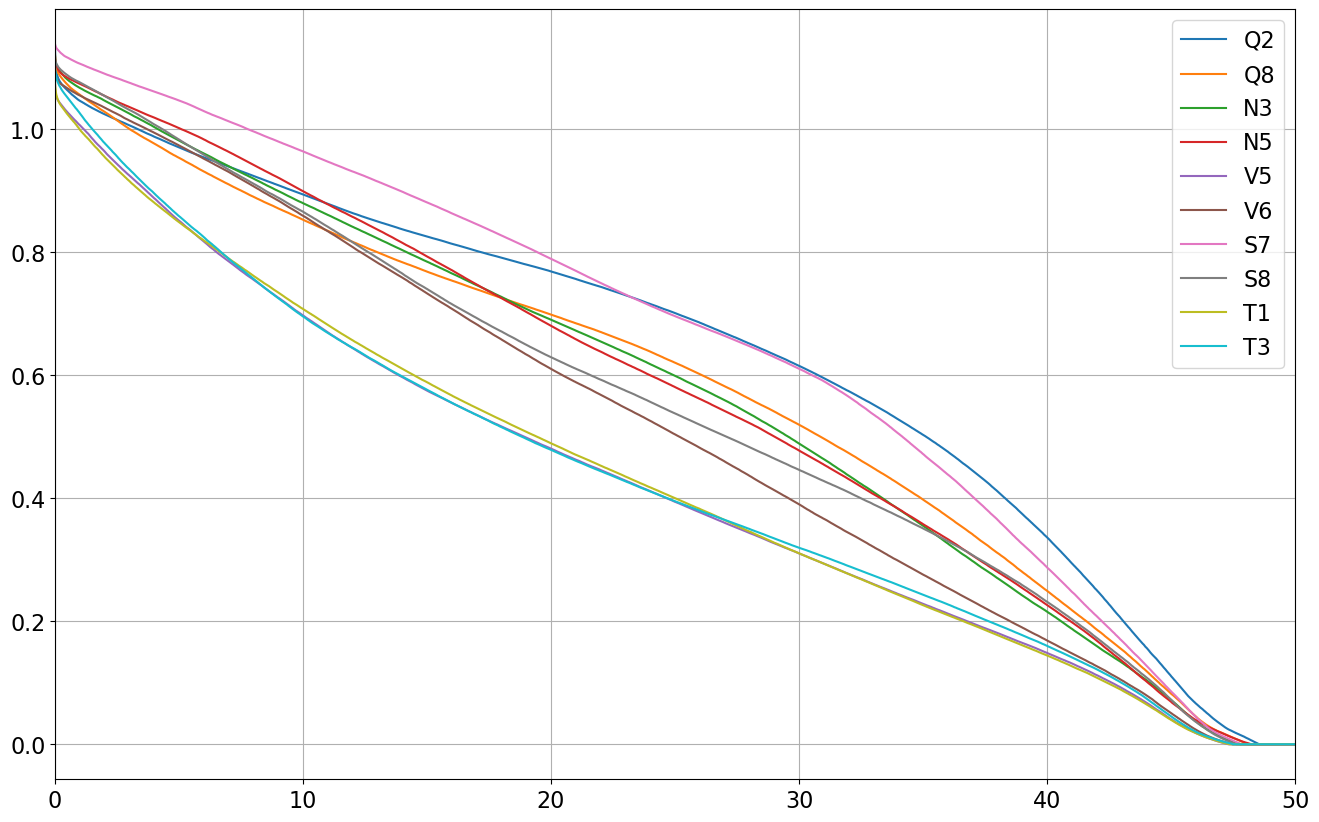

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
for r in regions:
    full_time_da = full_time(da=ds_raw[r])
    vals = np.sort(full_time_da.data)[::-1]
    percentiles = np.linspace(0,100,(len(vals)))
    ax.plot(percentiles, vals, label=r)
plt.legend()
# plt.axhline(0.2, color='r', linestyle='--')
# plt.xticks([0, 10, ])
plt.xlim(0,50)
plt.grid(True)

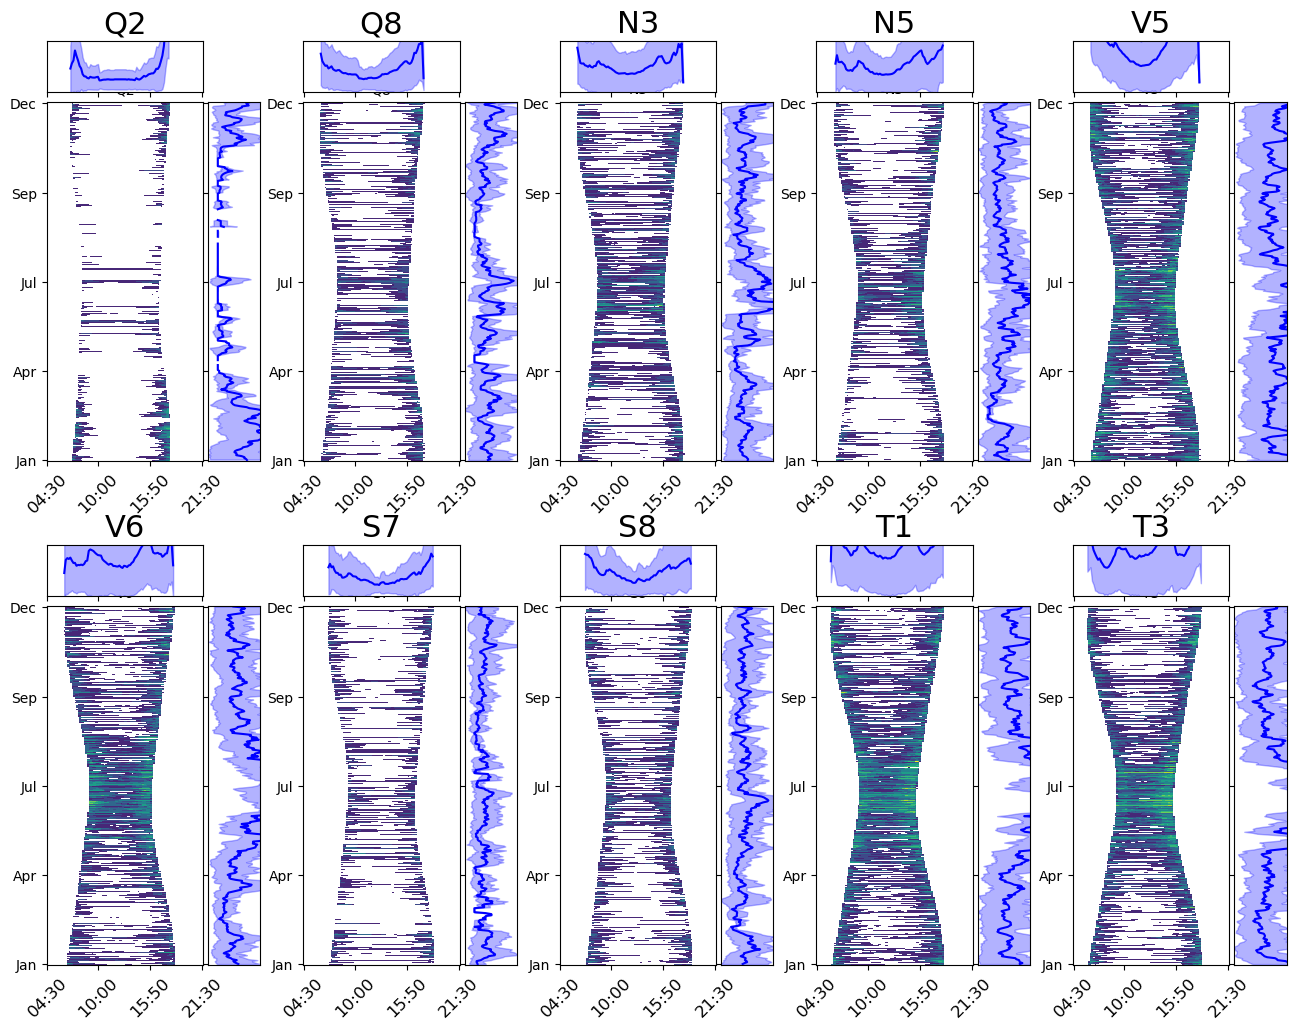

In [19]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)

# Create the colormap once
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0], sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1], sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_droughts(ds_aus[reg], threshold = 0.25, time=2)
    df = df.drop(df.columns[49], axis=1)
    df[df == 0] = np.nan

    # Heatmap
    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    ax_heatmap.set_title(reg, fontsize=10)

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
    ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
    ax_heatmap.set_yticks(yticks)
    ax_heatmap.set_yticklabels(ytick_labels, fontsize=10)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    line1, = ax_top.plot(mean_daily.values, color="blue", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_ylim(0.08,0.25)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="blue", label='Mean (annual)')
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_xlim(0.08, 0.25)

fig.colorbar(im, cax=cbar_ax).set_label('Solar Irradiance (normalized)', fontsize=12)
plt.show()

# Day/Year Heatmap

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

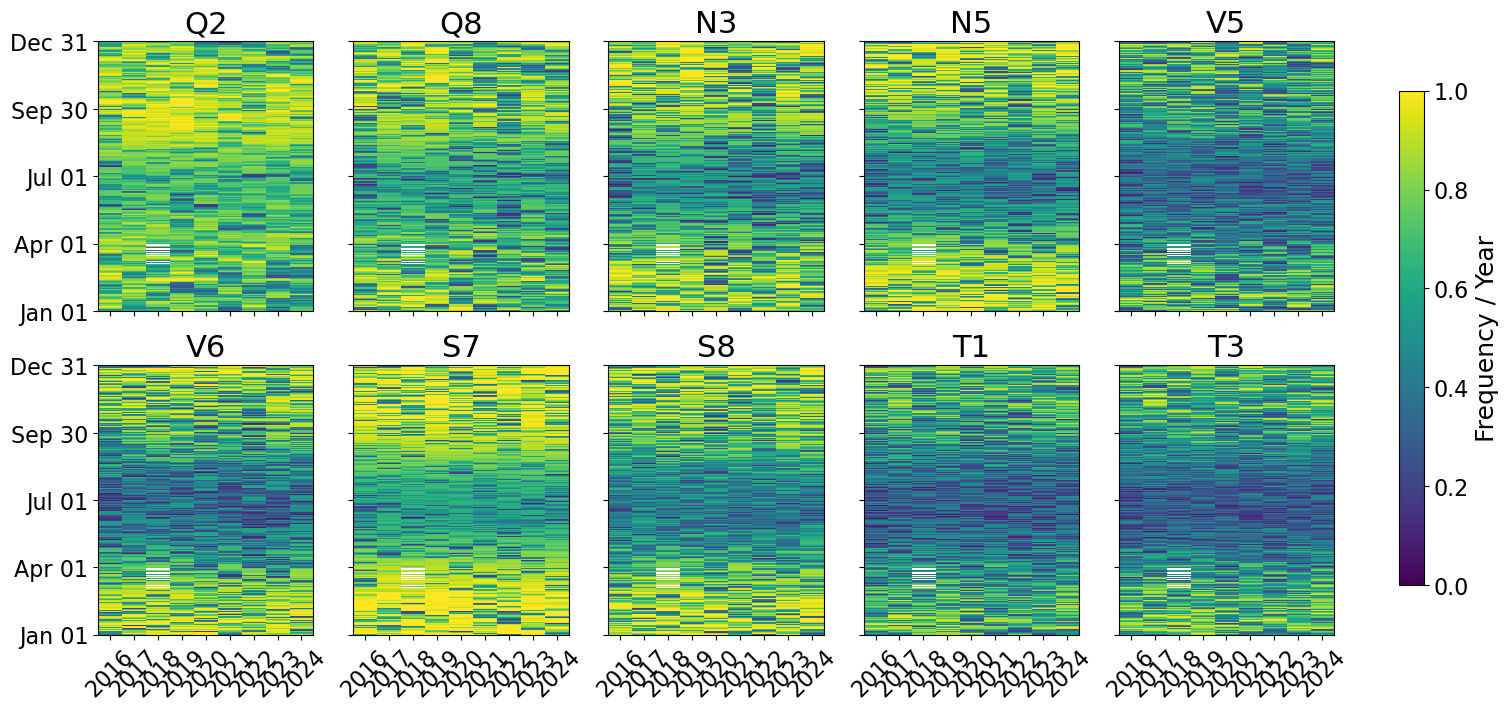

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
ax = ax.flatten()
daily = ds_aus.resample(time="1D").mean()

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None
for i, reg in enumerate(regions):
    df = solar_plotting.day_year_df(daily[reg])

    cmap = plt.cm.viridis
    cmap.set_bad(color='white')
    im = ax[i].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    ax[i].set_title(reg)
    xticks = np.arange(len(df.columns))
    xtick_labels = df.columns.astype(str)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    
    # Y-axis (Convert Day of Year → Month-Day)
    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)  # Select 10 evenly spaced day labels
    ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
    ax[i].set_yticks(yticks, ytick_labels)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Frequency / Year', fontsize=18)

plt.show()

# Coincident Droughts

In [74]:
threshold = 0.2 # consistent threshold for all data below

# array showing the number of regions in "drought" for each timestep
coincident_droughts = np.zeros(len(ds_aus.time))
for reg in regions:
    drought_data = xr.where(ds_aus[reg] < threshold, 1, 0).values
    coincident_droughts += drought_data
coincident_da = xr.DataArray(coincident_droughts, dims=ds_aus.dims, coords=ds_aus.coords)

hourly_rolling = ds_aus.rolling(time=6, center=False).mean()
coincident_droughts_hourly = np.zeros(len(hourly_rolling.time))
for reg in regions:
    drought_data = xr.where(hourly_rolling[reg] < threshold, 1, 0).values
    coincident_droughts_hourly += drought_data
coincident_da_hourly = xr.DataArray(coincident_droughts_hourly, dims=hourly_rolling.dims, coords=hourly_rolling.coords)

# array for the number of regions in "drought" based on daily average
daily = ds_aus.resample(time="1D").mean()
coincident_droughts_daily = np.zeros(len(daily.time))
for reg in regions:
    drought_data = xr.where(daily[reg] < threshold, 1, 0).values
    coincident_droughts_daily += drought_data
coincident_da_daily = xr.DataArray(coincident_droughts_daily, dims=daily.dims, coords=daily.coords)

# dataset of boolean vals showing if each region is in drought
coincident_drought_ds = ds_aus < threshold

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

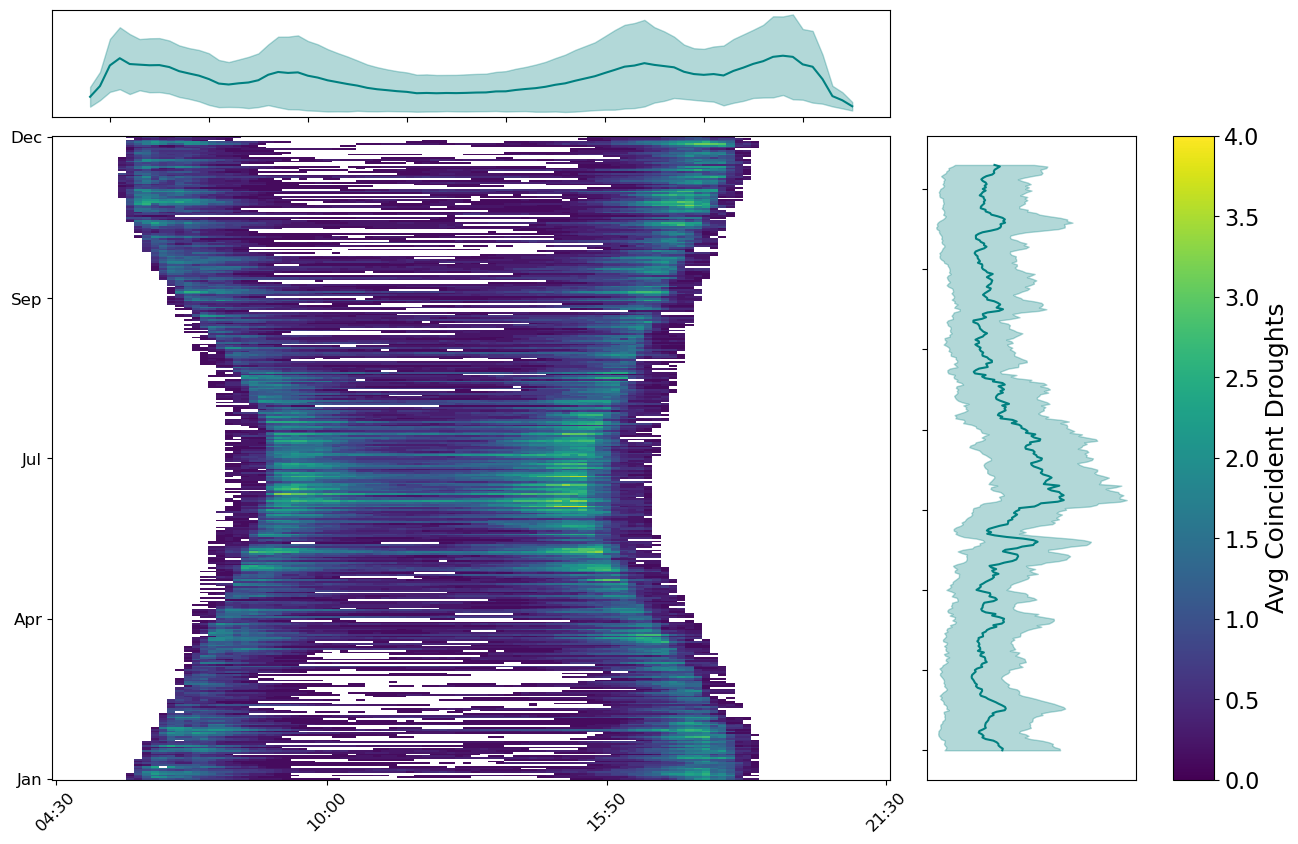

In [22]:
# Prepare data
df = solar_plotting.day_time_df(coincident_da)
df = df.drop(df.columns[49], axis=1)
df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# Axis ticks - x
xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

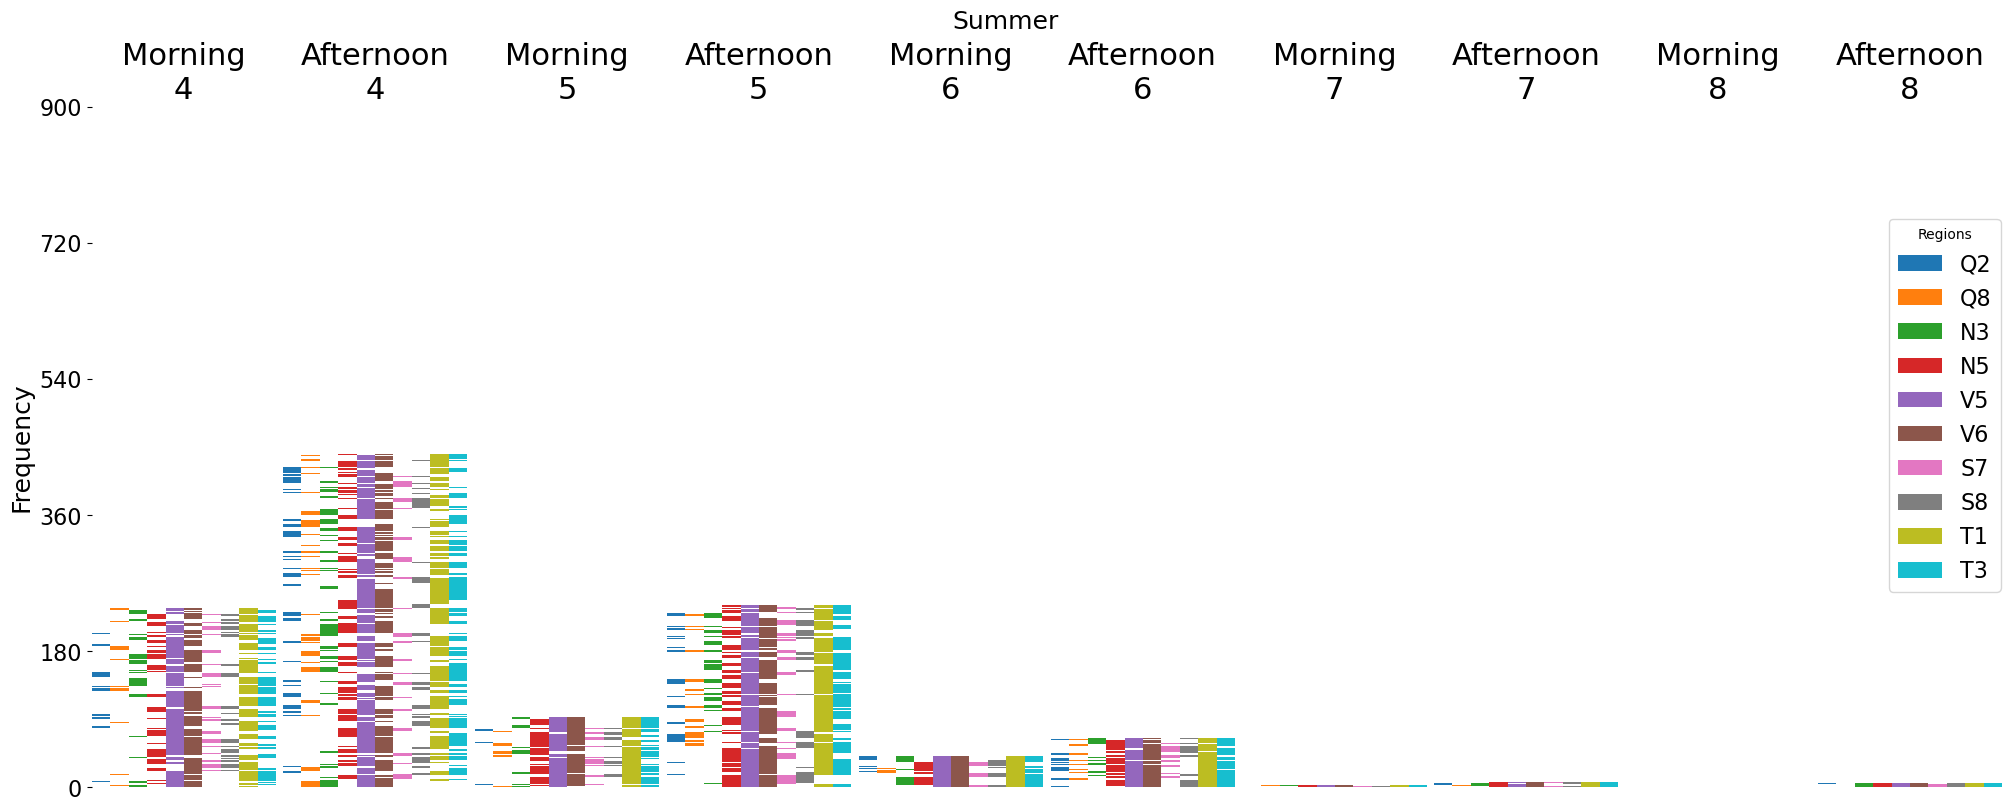

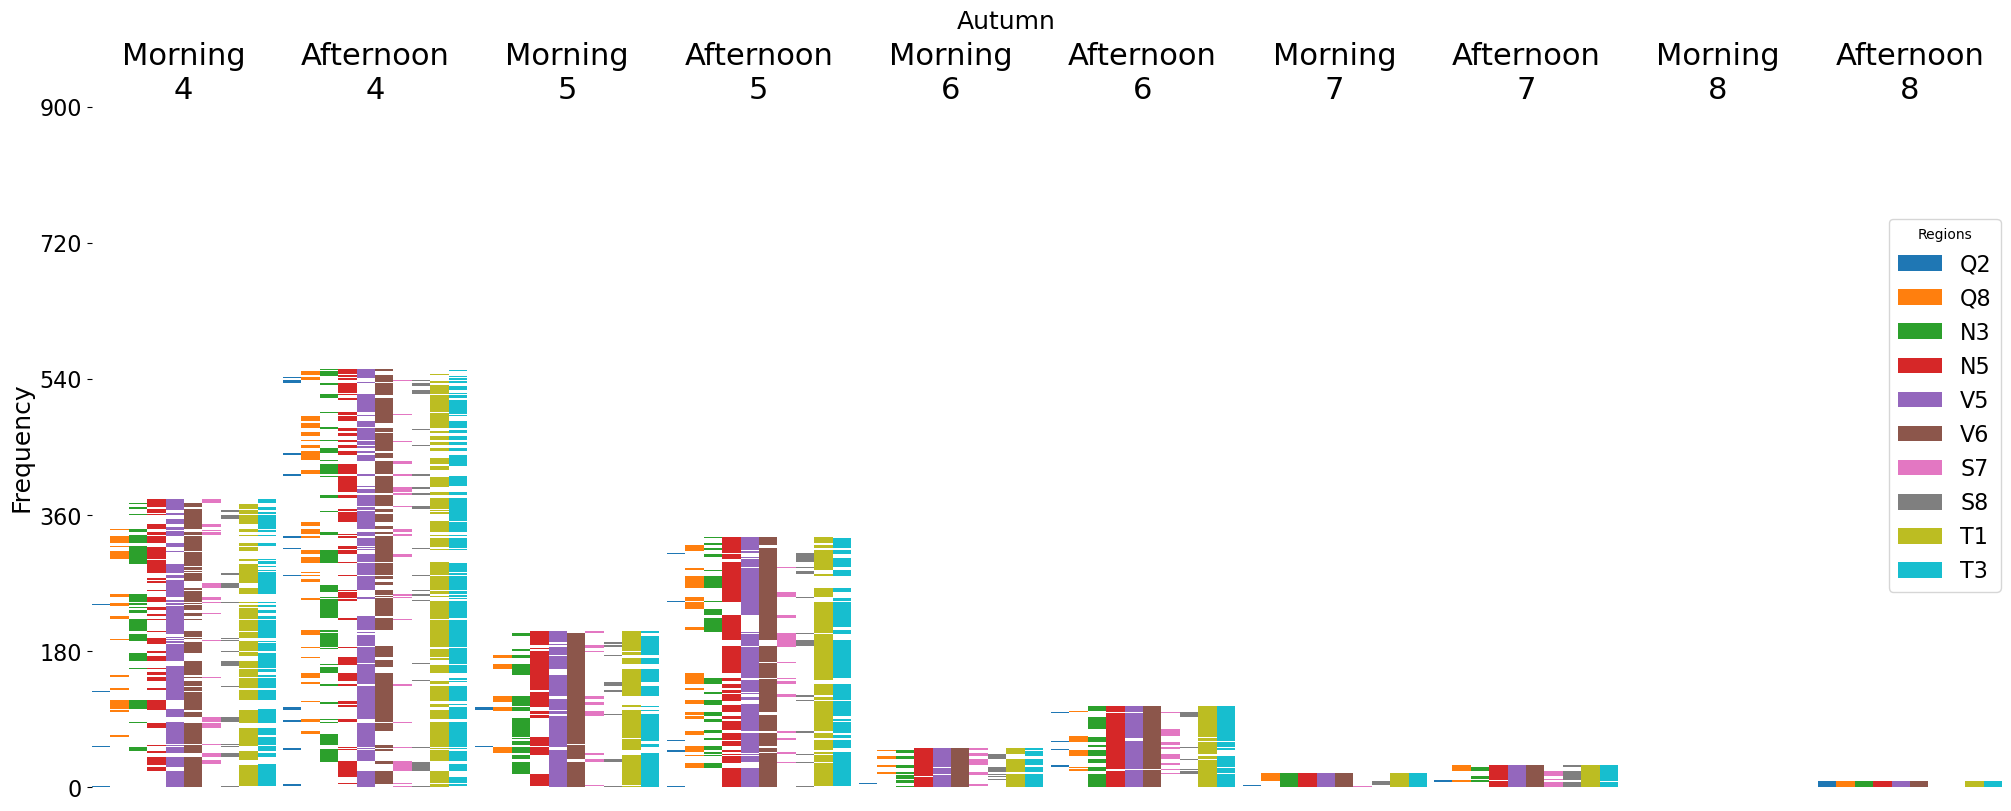

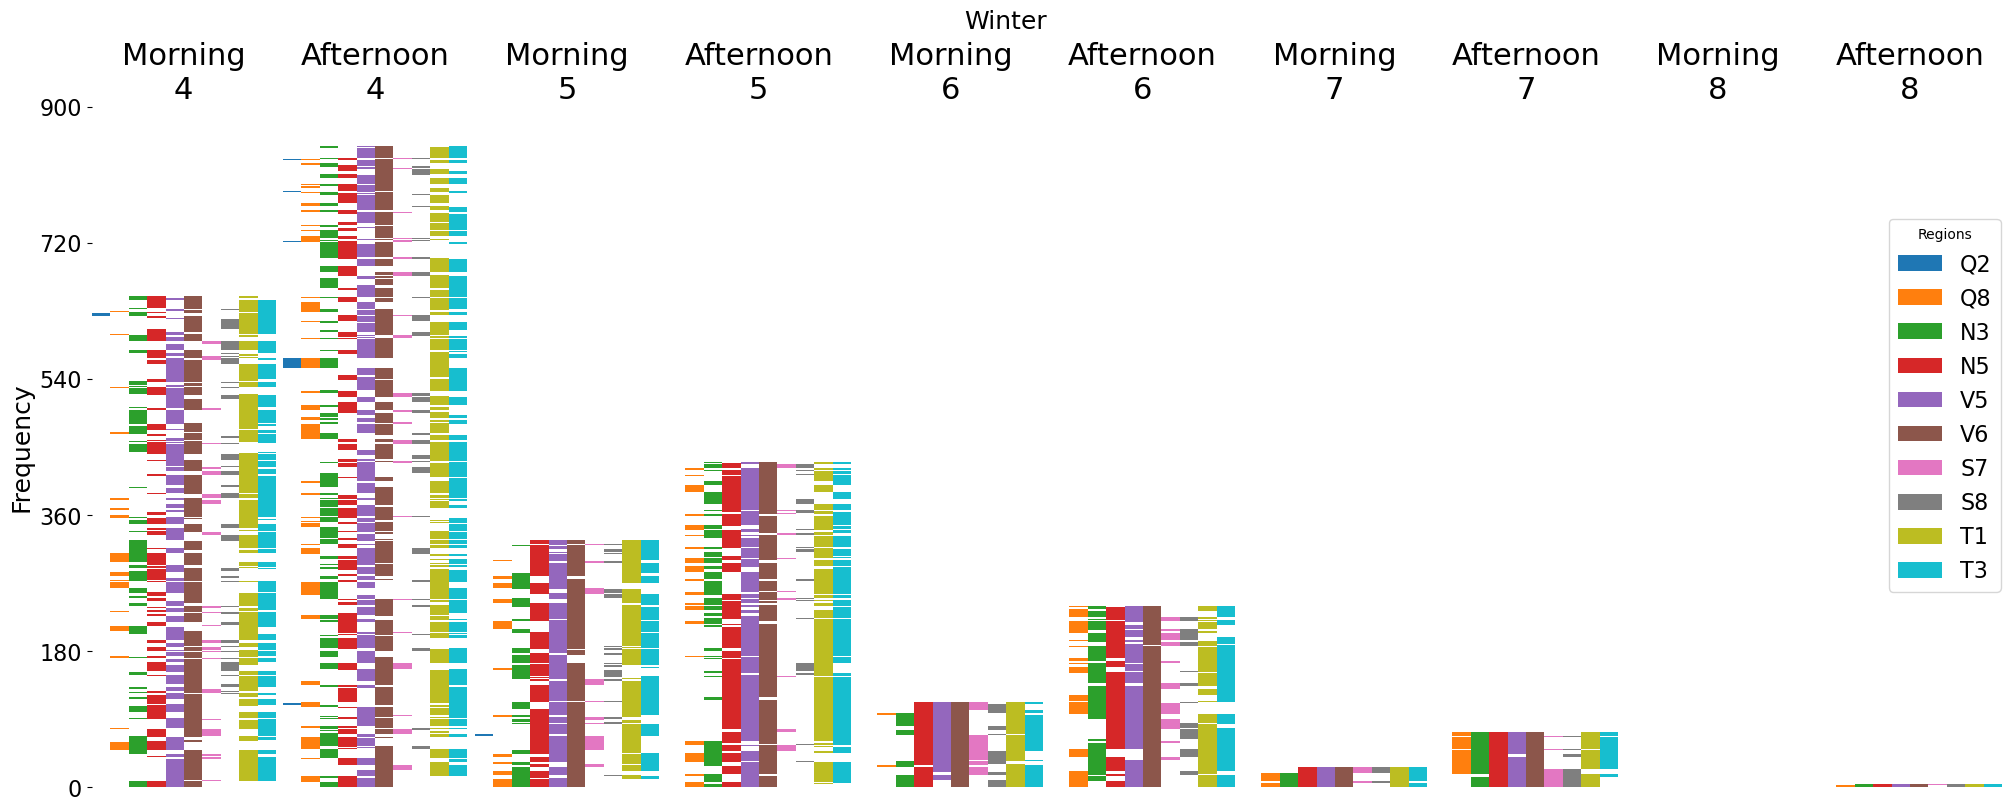

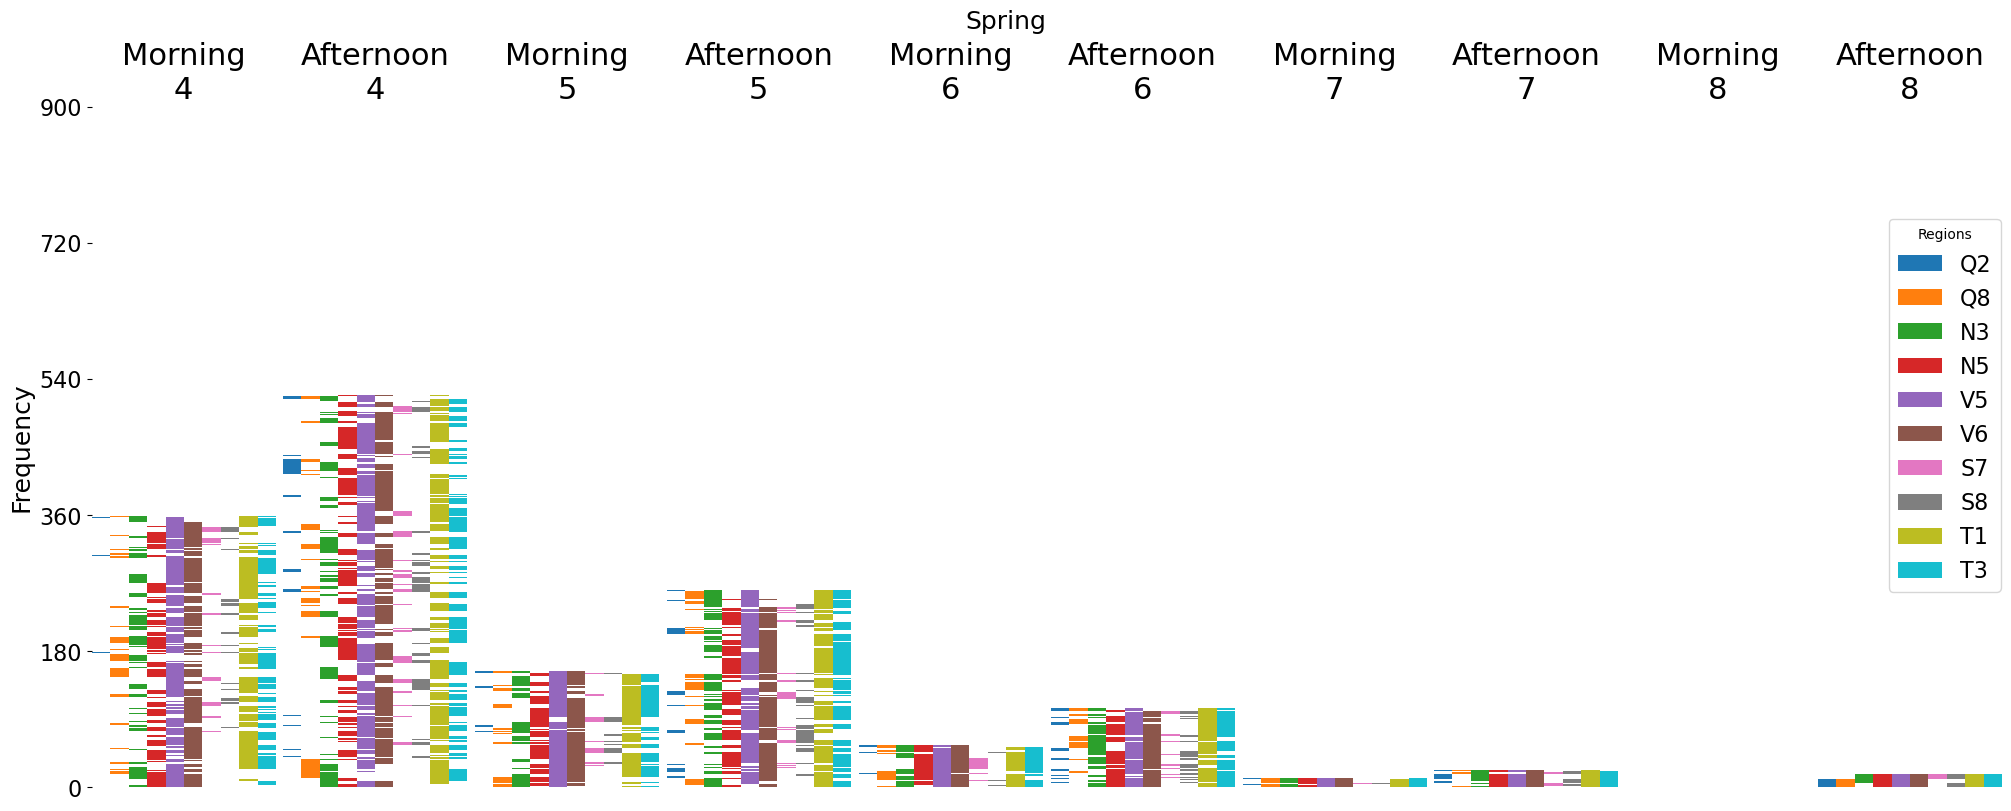

In [43]:
seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

for season in seasons:
    seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True)
    morning_data = seasonal_data.where(seasonal_data.time.dt.hour < 12, drop=True)
    afternoon_data = seasonal_data.where(seasonal_data.time.dt.hour >= 12, drop=True)

    fig, axes = plt.subplots(
        nrows=1, ncols=10, figsize=(20, 8),
        constrained_layout=True
    )

    all_regions = list(regions)  # ensure legend includes all
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_regions)))[:, :3]

    i = 0
    for num_droughts in range(4, 9):
        for tod_label, time_of_day in zip(["Morning", "Afternoon"], [morning_data, afternoon_data]):
            times = time_of_day[time_of_day == num_droughts].time.data

            if len(times) == 0:
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_title(f"{tod_label}\n{num_droughts}")
                for spine in axes[i].spines.values():
                    spine.set_visible(False)
                i += 1
                continue

            # Build DataFrame
            data = {
                reg: coincident_drought_ds[reg].sel(time=times).data.astype(int)
                for reg in all_regions
            }
            df = pd.DataFrame(data, index=times)

            rgb_img = np.ones((len(df), len(df.columns), 3))
            for j, col in enumerate(df.columns):
                rgb_img[df[col].values == 1, j, :] = colors[j]

            axes[i].imshow(rgb_img, aspect='auto', interpolation='none')
            axes[i].set_title(f"{tod_label}\n{num_droughts}")
            axes[i].set_xticks([])
            axes[i].set_xticklabels([])
            axes[i].set_yticks([])
            ylim=900
            axes[0].set_yticks(np.linspace(0, ylim, 6, dtype=int))
            axes[0].set_ylabel("Frequency")
            axes[i].set_ylim(0, ylim)
            for spine in axes[i].spines.values():
                spine.set_visible(False)

            i += 1

    # Legend
    legend_elements = [Patch(facecolor=colors[j], label=reg) for j, reg in enumerate(all_regions)]
    fig.legend(handles=legend_elements, loc='center right', title='Regions')
    fig.suptitle(f"{season.capitalize()}", fontsize=18)
    plt.show()

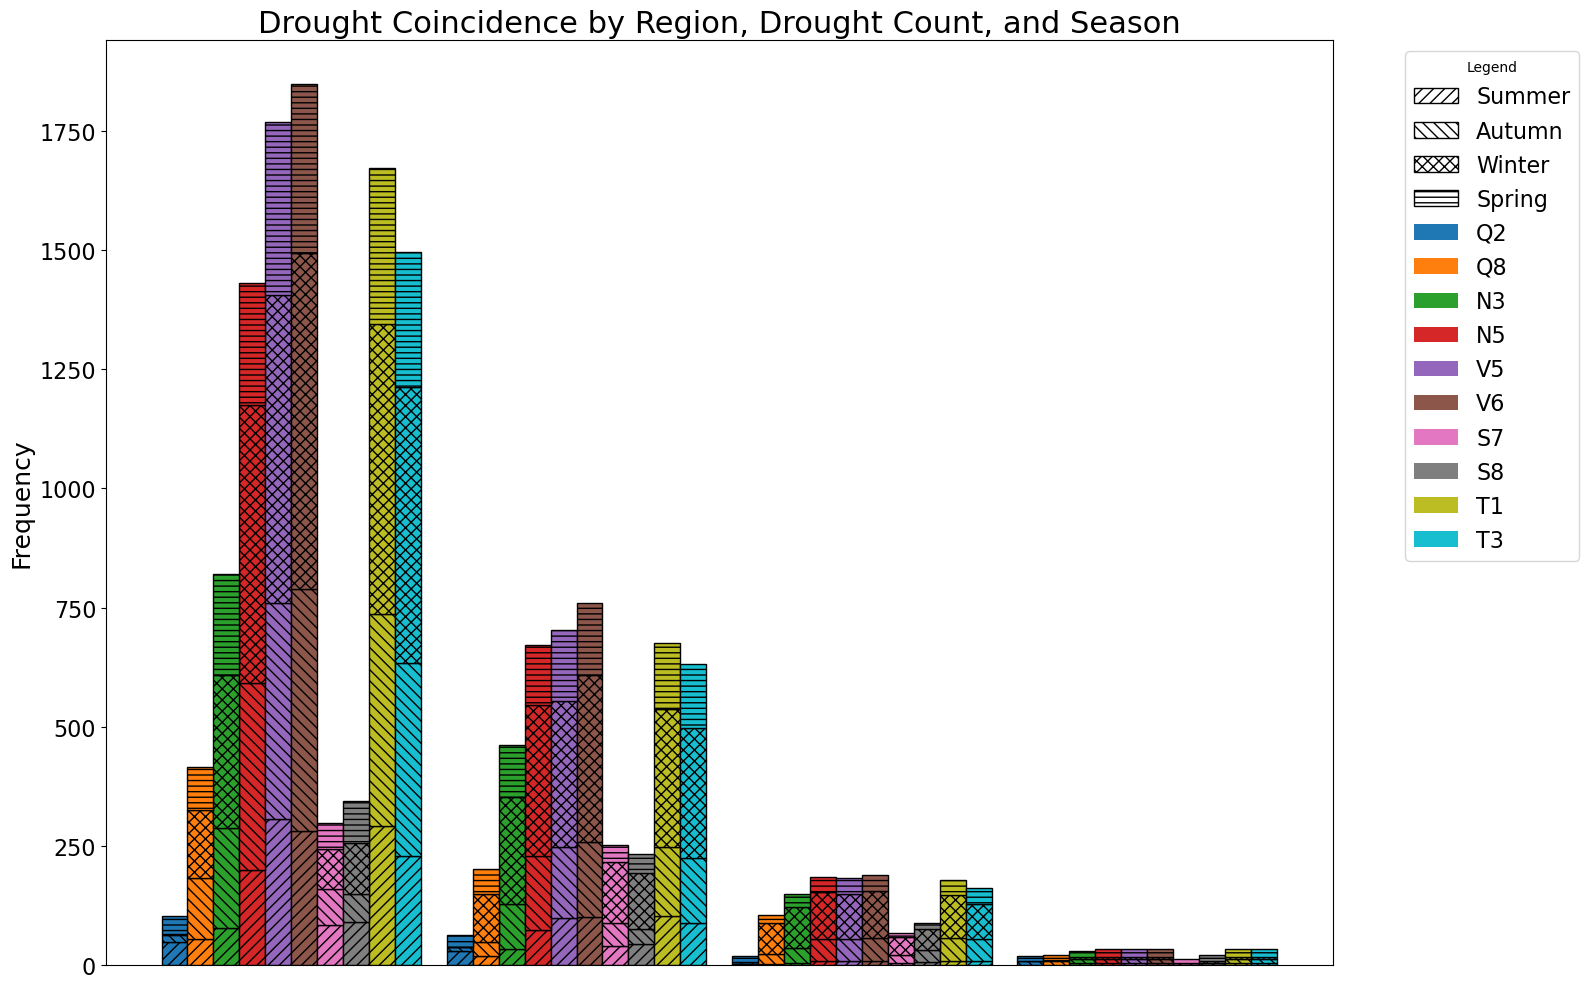

In [76]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16, 10))

seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

season_hatches = {
    'summer': '///',
    'autumn': '\\\\\\',
    'winter': 'xxx',
    'spring': '---'
}

# Unique colors per region
region_colors = {
    region: plt.cm.tab10(i % 10) for i, region in enumerate(regions)
}

num_droughts_range = list(range(5, 9))
n_droughts = len(num_droughts_range)
n_regions = len(regions)
bar_width = 0.2
group_spacing = 0.2

x_labels = []
x_positions = []
season_data_by_region = {season: [] for season in seasons}
region_ids = []

# Compute data
for i_d, num_droughts in enumerate(num_droughts_range):
    group_start = i_d * (n_regions * bar_width + group_spacing)

    for i_r, region in enumerate(regions):
        x = group_start + i_r * bar_width
        x_positions.append(x)
        x_labels.append(f"{region}\n({num_droughts})")
        region_ids.append(region)

        for season_name, months in seasons.items():
            seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(months), drop=True)
            times = seasonal_data[seasonal_data == num_droughts].time.data
            value = coincident_drought_ds[region].sel(time=times).data.sum()
            season_data_by_region[season_name].append(value)

# Stack bars with region colors and season hatches
bottom = np.zeros(len(x_positions))
for season_name, values in season_data_by_region.items():
    for idx, (x, height) in enumerate(zip(x_positions, values)):
        region = region_ids[idx]
        ax.bar(
            x,
            height,
            bottom=bottom[idx],
            width=bar_width,
            color=region_colors[region],
            edgecolor='black',
            hatch=season_hatches[season_name]
        )
        bottom[idx] += height

# Formatting
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel("Frequency")
ax.set_title("Drought Coincidence by Region, Drought Count, and Season")

# Legend
from matplotlib.patches import Patch
season_legend = [Patch(facecolor='white', hatch=h, edgecolor='black', label=season.capitalize())
                 for season, h in season_hatches.items()]
region_legend = [Patch(facecolor=color, label=region) for region, color in region_colors.items()]
ax.legend(handles=season_legend + region_legend, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

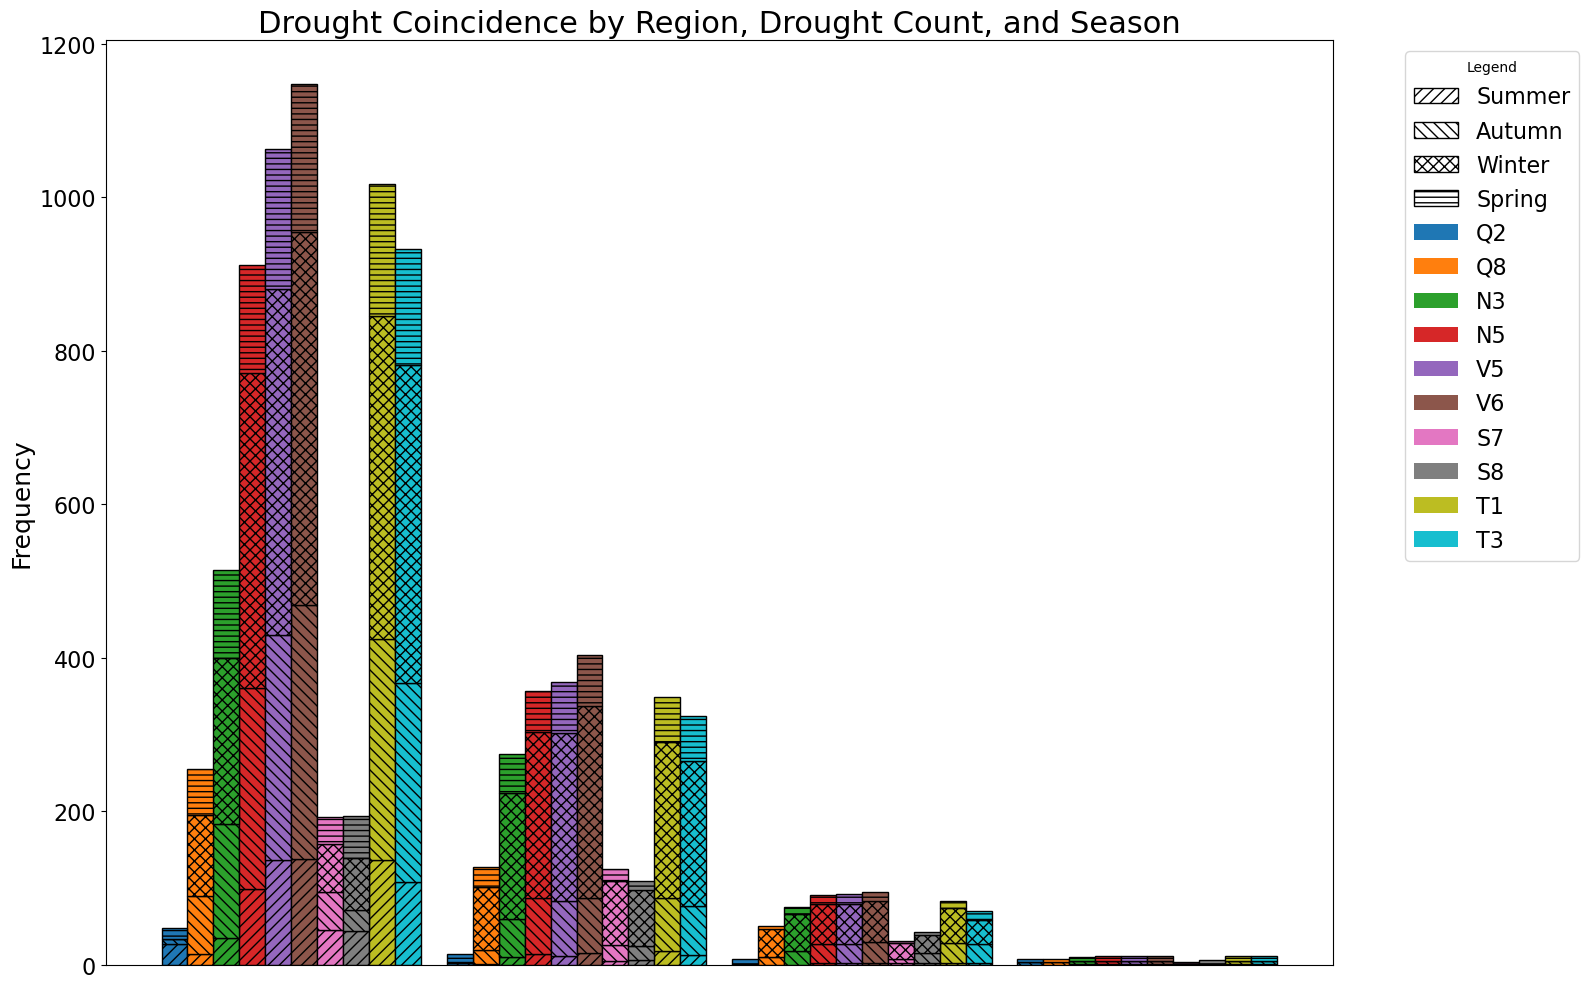

In [77]:
fig, ax = plt.subplots(figsize=(16, 10))

seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

season_hatches = {
    'summer': '///',
    'autumn': '\\\\\\',
    'winter': 'xxx',
    'spring': '---'
}

# Unique colors per region
region_colors = {
    region: plt.cm.tab10(i % 10) for i, region in enumerate(regions)
}

num_droughts_range = list(range(5, 9))
n_droughts = len(num_droughts_range)
n_regions = len(regions)
bar_width = 0.2
group_spacing = 0.2

x_labels = []
x_positions = []
season_data_by_region = {season: [] for season in seasons}
region_ids = []

# Compute data
for i_d, num_droughts in enumerate(num_droughts_range):
    group_start = i_d * (n_regions * bar_width + group_spacing)

    for i_r, region in enumerate(regions):
        x = group_start + i_r * bar_width
        x_positions.append(x)
        x_labels.append(f"{region}\n({num_droughts})")
        region_ids.append(region)

        for season_name, months in seasons.items():
            seasonal_data = coincident_da_hourly.where(coincident_da_hourly.time.dt.month.isin(months), drop=True)
            times = seasonal_data[seasonal_data == num_droughts].time.data
            value = coincident_drought_ds[region].sel(time=times).data.sum()
            season_data_by_region[season_name].append(value)

# Stack bars with region colors and season hatches
bottom = np.zeros(len(x_positions))
for season_name, values in season_data_by_region.items():
    for idx, (x, height) in enumerate(zip(x_positions, values)):
        region = region_ids[idx]
        ax.bar(
            x,
            height,
            bottom=bottom[idx],
            width=bar_width,
            color=region_colors[region],
            edgecolor='black',
            hatch=season_hatches[season_name]
        )
        bottom[idx] += height

# Formatting
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel("Frequency")
ax.set_title("Drought Coincidence by Region, Drought Count, and Season")

# Legend
from matplotlib.patches import Patch
season_legend = [Patch(facecolor='white', hatch=h, edgecolor='black', label=season.capitalize())
                 for season, h in season_hatches.items()]
region_legend = [Patch(facecolor=color, label=region) for region, color in region_colors.items()]
ax.legend(handles=season_legend + region_legend, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
def regional_correlations(ds):
    # Stack each variable into a new 'variable' dimension
    data = xr.concat(
        [ds[var].expand_dims(variable=[var]) for var in ds.data_vars],
        dim='variable'
    )
    data = data.dropna(dim='time', how='any')
    data = data.transpose('variable', 'time')  # shape: (variable, time)
    
    # Compute pairwise correlations
    var_names = data['variable'].values
    n = len(var_names)

    corr = np.empty((n, n), dtype=np.float64)

    for i in range(n):
        for j in range(n):
            corr[i, j] = xr.corr(data.sel(variable=var_names[i]),
                                 data.sel(variable=var_names[j]),
                                 dim='time').item()

    return pd.DataFrame(corr, index=var_names, columns=var_names)

In [14]:
corr_df = regional_correlations(ds) #.iloc[:-1,:-1]

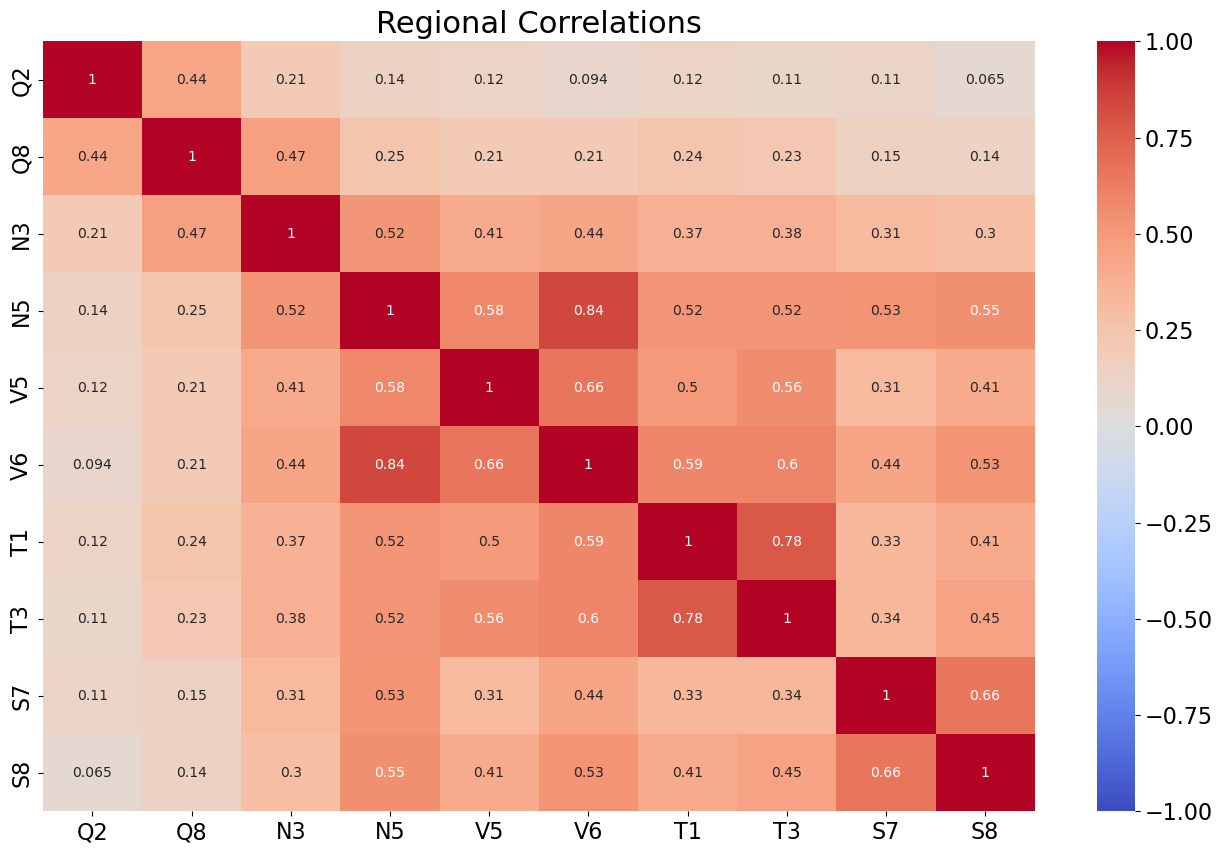

In [15]:
plt.figure(figsize=(16,10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Regional Correlations')
plt.show()

In [16]:
coincident_dict = {}
for reg in regions:
    coincident_dict[reg] = []
    for second_reg in regions:
        total = sum(xr.where(ds[reg] < 0.2, 1, 0).data)
        coincident = sum(xr.where((ds[reg] < 0.2) & (ds[second_reg] < 0.2), 1, 0).data)
        coincident_dict[reg].append(coincident/total)
coincident_df = pd.DataFrame(coincident_dict, index=coincident_dict.keys())

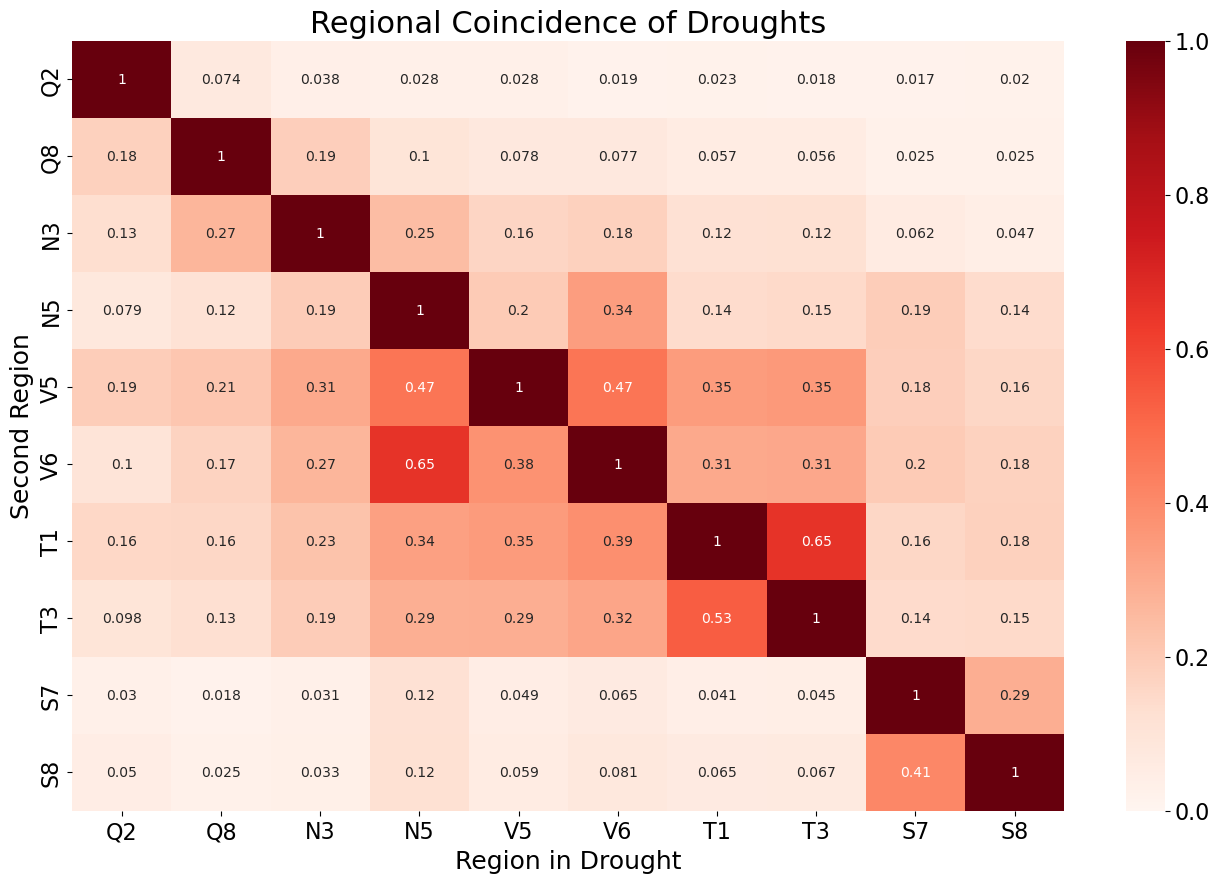

In [17]:
plt.figure(figsize=(16,10))
sns.heatmap(coincident_df, annot=True, cmap='Reds', vmin=0, vmax=1)
plt.title('Regional Coincidence of Droughts')
plt.xlabel('Region in Drought')
plt.ylabel('Second Region')
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


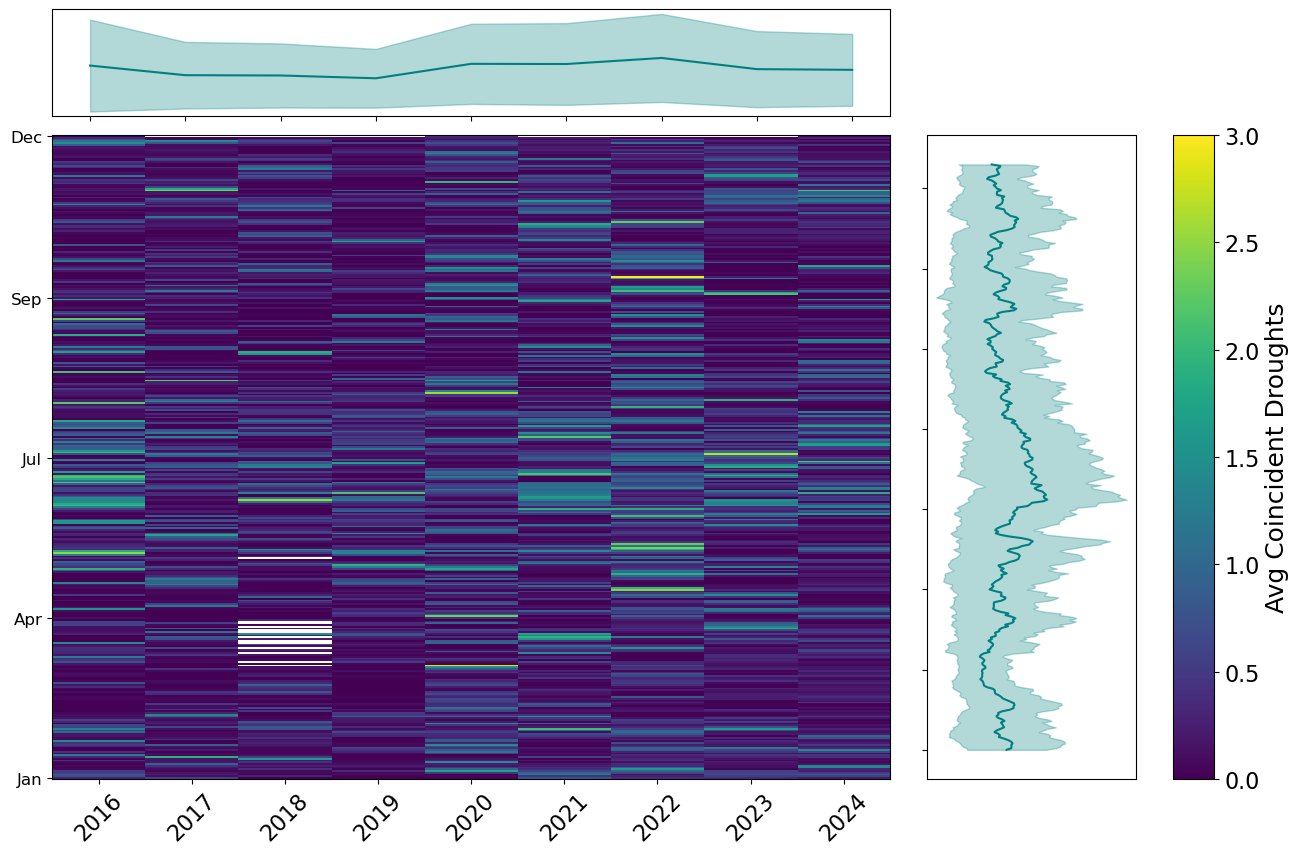

In [25]:
# Prepare data
# Prepare data
coincident_daily = coincident_da.resample(time="1D").mean()
df = solar_plotting.day_year_df(coincident_daily)
# df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=3, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# X-axis: years
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

# Worst Events

In [27]:
threshold = 0.26
data = ds_aus.total.dropna(dim='time').rolling(time=100).mean()
events = xr.where(data < threshold, data, np.nan).dropna(dim='time')
np.unique(events.time.to_index().date)

array([datetime.date(2016, 6, 18), datetime.date(2016, 6, 19),
       datetime.date(2016, 6, 20), datetime.date(2023, 7, 4),
       datetime.date(2023, 7, 5)], dtype=object)

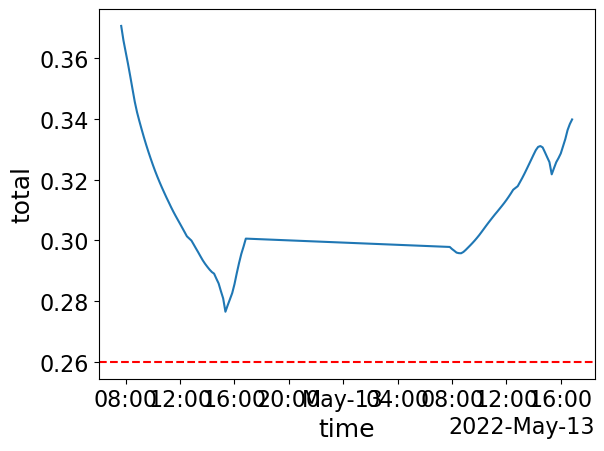

In [28]:
ds_aus.total.dropna(dim='time').rolling(time=100).mean().sel(time=slice('2022-05-12', '2022-05-13')).plot()
plt.axhline(threshold, color='r', linestyle = '--')

# Spectral Analysis

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering 

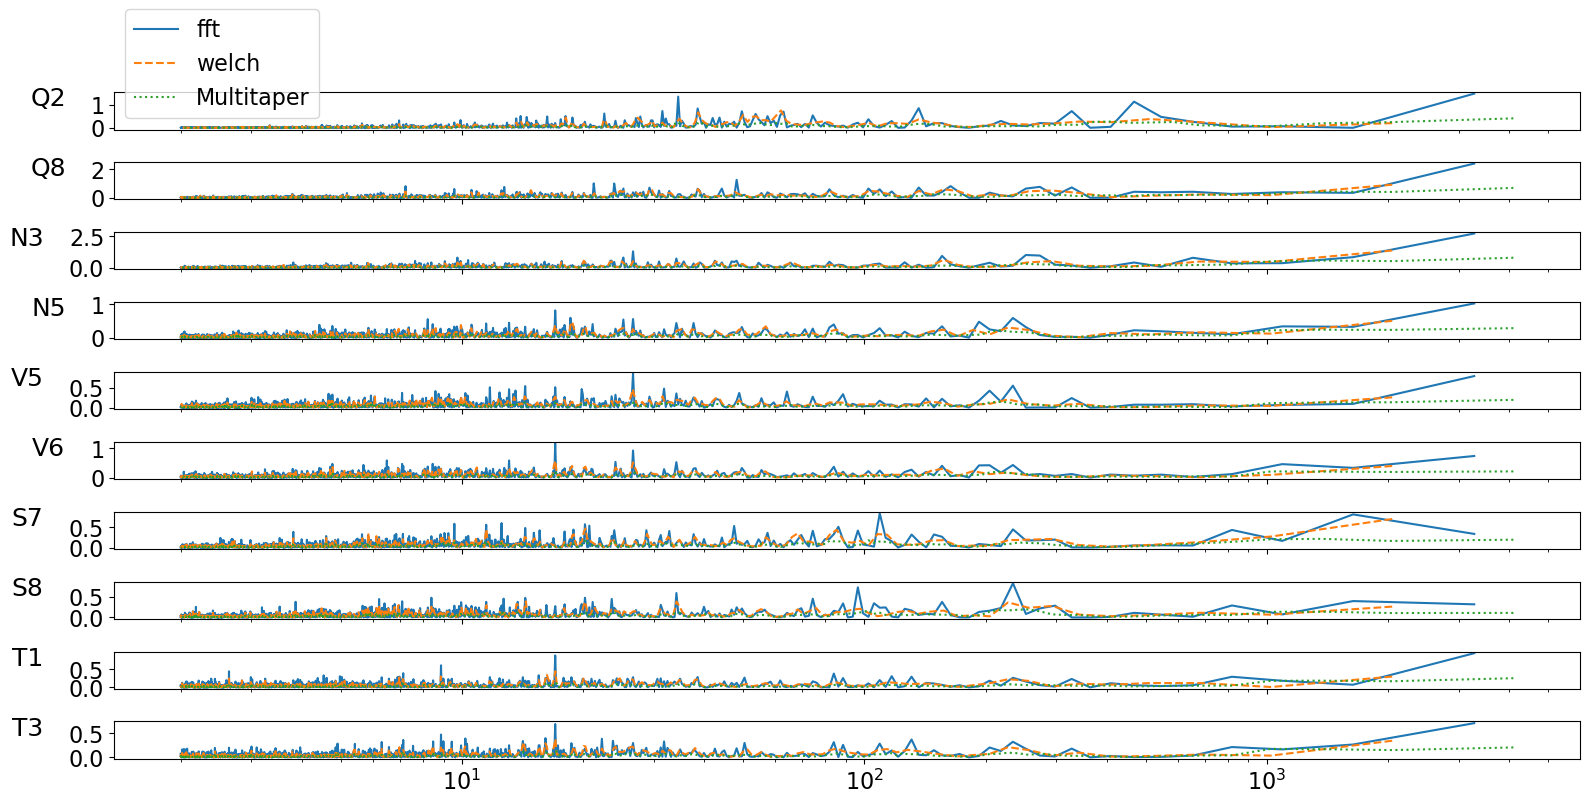

In [29]:
colours = ['red', 'orange', 'blue', 'green', 'purple']
time_res = '1D'
clim = True

fig, ax = plt.subplots(nrows = len(regions), ncols = 1, figsize=(16,8), sharex=True)

for i, reg in enumerate(regions):

    fft_periods, fft_power = solar_plotting.spectral_fft(da=ds_aus[reg], time_res=time_res, clim=clim)
    welch_periods, welch_power = solar_plotting.spectral_welch(da=ds_aus[reg], nperseg=2048, time_res=time_res, clim=clim)
    mt_periods, mt_power = solar_plotting.spectral_multitaper(da=ds_aus[reg], NW=2.5, k=4, time_res=time_res, clim=clim)
    mt_mask = mt_periods >= np.min(fft_periods)
    
    ax[i].semilogx(fft_periods, fft_power, label='fft')
    ax[i].semilogx(welch_periods, welch_power, label='welch', linestyle = '--')
    ax[i].semilogx(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', linestyle = ':')
    ax[i].set_ylabel(reg, rotation=0, labelpad=30)
    # ax[i].set_xlim(1,100)
    # ax[i].set_ylim(0,20)
    
    fig.gca().invert_xaxis()
ax[0].legend()
plt.tight_layout()

In [30]:
# Wavelet

variables = ['Q', 'N', 'V', 'S', 'T']

for var in variables:
    # daily = ds_aus[var].resample(time="1D").mean()
    clean = ds_aus[var].dropna(dim="time")
    data = clean - clean.mean(dim="time")
    signal = data.values
    
    scales = np.arange(1, 100)
    coefficients, freqs = pywt.cwt(signal, scales=scales, wavelet='morl', sampling_period=1)
    
    # Compute power and apply log scale (add small constant to avoid log(0))
    power = np.abs(coefficients) ** 2
    log_power = np.log2(power + 1e-8)
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(power,
                    extent=[0, len(signal), scales[-1], scales[0]], vmax = 3,
                    aspect='auto', cmap='RdYlBu_r')
    
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(im)
    cbar.set_label("Power")
    
    plt.xlabel("Time (samples since start)")
    plt.ylabel("Period (days)")
    plt.title("Wavelet Power Spectrum")
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

KeyError: "No variable named 'Q'. Variables on the dataset include ['Q2', 'Q8', 'N3', 'N5', 'V5', ..., 'S8', 'T1', 'T3', 'time', 'total']"